In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("nsw_property_data.csv")


date_column = 'contract_date' 

# Convert to datetime
df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

# Filter for rows from 2019 onwards
df_filtered = df[df[date_column].dt.year >= 2019]

# Save the trimmed dataset
df_filtered.to_csv("nsw_property_data_2019_onwards.csv", index=False)

print(f"Original size: {len(df)} rows")
print(f"Filtered size: {len(df_filtered)} rows")
print("Saved as nsw_property_data_2019_onwards.csv")

Original size: 4854814 rows
Filtered size: 954500 rows
Saved as nsw_property_data_2019_onwards.csv


In [2]:
df1 = pd.read_csv("nsw_property_data_2019_onwards.csv")  # Load the filtered dataset to verify
df1.head()  # Display the first few rows of the filtered dataset

,property_id,download_date,council_name,purchase_price,address,post_code,property_type,strata_lot_number,property_name,area,area_type,contract_date,settlement_date,zoning,nature_of_property,primary_purpose,legal_description
0,1672682.0,2024-02-19,BYRON,1120000.0,"129 MAFEKING RD, GOONENGERRY",2482.0,house,NaN,NaN,3.419,H,2024-01-19,2024-02-15,RU2,R,RESIDENCE,1/607703
1,1665192.0,2024-02-19,BYRON,2800000.0,"38 AVOCADO CRES, EWINGSDALE",2481.0,house,NaN,NaN,3420.000,M,2023-11-10,2024-02-15,R5,R,RESIDENCE,25/806200
2,1676023.0,2024-02-19,BYRON,1500000.0,"20 ROYAL AVE, SOUTH GOLDEN BEACH",2483.0,house,NaN,NaN,727.200,M,2023-11-17,2024-02-09,R2,R,RESIDENCE,213/31166
3,1670957.0,2024-02-19,BYRON,985000.0,"2 INDERWONG AVE, OCEAN SHORES",2483.0,house,NaN,NaN,992.700,M,2023-09-27,2024-02-12,R2,R,RESIDENCE,1101/241074
4,1673846.0,2024-02-19,BYRON,720000.0,"52 NAROOMA DR, OCEAN SHORES",2483.0,house,NaN,NaN,771.400,M,2024-02-06,2024-02-09,R2,R,RESIDENCE,337/238455


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

# ========= CONFIG =========
IN_PATH  = "nsw_property_data_2019_onwards.csv"   # <- your input file
OUT_CSV  = "nsw_property_data_cleaned_2019_onwards.csv"
EVIDENCE_SUMMARY_CSV = "evidence_cleaning_summary.csv"
EVIDENCE_BEFORE_AFTER_CSV = "evidence_before_after_sample.csv"

# Outlier thresholds (adjust if needed)
PRICE_MIN = 10_000
PRICE_MAX = 20_000_000

# Core fields needed for analysis/visuals (drop rows missing these)
CORE_FIELDS = ["purchase_price", "council_name", "contract_date"]

# String columns to standardize (strip whitespace)
STR_COLS = [
    "council_name", "address", "property_type", "strata_lot_number",
    "property_name", "area_type", "zoning", "nature_of_property",
    "primary_purpose", "legal_description"
]

# Date columns to parse
DATE_COLS = ["contract_date", "settlement_date", "download_date"]

# ========= LOAD =========
df = pd.read_csv(IN_PATH)
before_shape = df.shape
before_preview = df.sample(8, random_state=7).copy()  # for before/after evidence

# ========= CLEAN =========
clean = df.copy()

# 1) Trim whitespace for string columns (only those that exist)
for col in STR_COLS:
    if col in clean.columns:
        clean[col] = clean[col].astype("string").str.strip()

# 2) Consistent casing
if "council_name" in clean.columns:
    clean["council_name"] = clean["council_name"].str.title()

if "property_type" in clean.columns:
    clean["property_type"] = clean["property_type"].str.capitalize()

if "area_type" in clean.columns:
    clean["area_type"] = clean["area_type"].str.upper()

if "primary_purpose" in clean.columns:
    clean["primary_purpose"] = clean["primary_purpose"].str.title()

# 3) Type conversions
for c in ["purchase_price", "area", "post_code"]:
    if c in clean.columns:
        clean[c] = pd.to_numeric(clean[c], errors="coerce")

if "post_code" in clean.columns:
    clean["post_code"] = clean["post_code"].round().astype("Int64")

# 4) Dates to datetime
for dc in DATE_COLS:
    if dc in clean.columns:
        clean[dc] = pd.to_datetime(clean[dc], errors="coerce")

# 5) Remove obvious price outliers (keep NaNs to avoid losing valid rows w/ missing price)
initial_rows = len(clean)
if "purchase_price" in clean.columns:
    mask_price = clean["purchase_price"].isna() | (
        (clean["purchase_price"] >= PRICE_MIN) & (clean["purchase_price"] <= PRICE_MAX)
    )
    clean = clean[mask_price]
removed_outliers = initial_rows - len(clean)

# 6) Drop exact duplicate rows
before_dedup = len(clean)
clean = clean.drop_duplicates()
removed_dupes = before_dedup - len(clean)

# 7) Helper: contract_year
if "contract_date" in clean.columns:
    clean["contract_year"] = clean["contract_date"].dt.year

# 8) Drop rows missing core fields (only those core fields that exist)
core_existing = [c for c in CORE_FIELDS if c in clean.columns]
before_core = len(clean)
if core_existing:
    clean = clean.dropna(subset=core_existing)
removed_core_na = before_core - len(clean)

# 9) Round price to whole dollars and use Int64 (nullable ints)
if "purchase_price" in clean.columns:
    clean["purchase_price"] = clean["purchase_price"].round(0).astype("Int64")

after_shape = clean.shape

# ========= EVIDENCE TABLES =========
# Before/After sample (align by original sample indices)
sample_idx = before_preview.index
before_sample = df.loc[sample_idx].copy()
after_sample = clean.reindex(sample_idx).copy()
before_after = pd.concat(
    [before_sample.add_prefix("Before_"), after_sample.add_prefix("After_")],
    axis=1
)

summary_rows = [
    ("Rows before", before_shape[0]),
    ("Rows after", after_shape[0]),
    ("Columns (after)", after_shape[1]),
    ("Removed as outliers (price)", removed_outliers),
    ("Removed as duplicates", removed_dupes),
    ("Removed missing core fields", removed_core_na),
]
summary_df = pd.DataFrame(summary_rows, columns=["Metric", "Value"])

# ========= SAVE OUTPUTS =========
clean.to_csv(OUT_CSV, index=False)
summary_df.to_csv(EVIDENCE_SUMMARY_CSV, index=False)
before_after.to_csv(EVIDENCE_BEFORE_AFTER_CSV, index=False)

print("Saved cleaned data ->", OUT_CSV)
print("Saved cleaning summary ->", EVIDENCE_SUMMARY_CSV)
print("Saved before/after sample ->", EVIDENCE_BEFORE_AFTER_CSV)
print("\n--- STATS ---")
print(summary_df.to_string(index=False))


Saved cleaned data -> nsw_property_data_cleaned_2019_onwards.csv
Saved cleaning summary -> evidence_cleaning_summary.csv
Saved before/after sample -> evidence_before_after_sample.csv

--- STATS ---
                     Metric  Value
                Rows before 954500
                 Rows after 947413
            Columns (after)     18
Removed as outliers (price)   6803
      Removed as duplicates    284
Removed missing core fields      0


In [4]:
df2 = pd.read_csv("nsw_property_data_cleaned_2019_onwards.csv") 
df2.head() # Load the cleaned dataset to verify

,property_id,download_date,council_name,purchase_price,address,post_code,property_type,strata_lot_number,property_name,area,area_type,contract_date,settlement_date,zoning,nature_of_property,primary_purpose,legal_description,contract_year
0,1672682.0,2024-02-19,Byron,1120000,"129 MAFEKING RD, GOONENGERRY",2482.0,House,NaN,NaN,3.419,H,2024-01-19,2024-02-15,RU2,R,Residence,1/607703,2024
1,1665192.0,2024-02-19,Byron,2800000,"38 AVOCADO CRES, EWINGSDALE",2481.0,House,NaN,NaN,3420.000,M,2023-11-10,2024-02-15,R5,R,Residence,25/806200,2023
2,1676023.0,2024-02-19,Byron,1500000,"20 ROYAL AVE, SOUTH GOLDEN BEACH",2483.0,House,NaN,NaN,727.200,M,2023-11-17,2024-02-09,R2,R,Residence,213/31166,2023
3,1670957.0,2024-02-19,Byron,985000,"2 INDERWONG AVE, OCEAN SHORES",2483.0,House,NaN,NaN,992.700,M,2023-09-27,2024-02-12,R2,R,Residence,1101/241074,2023
4,1673846.0,2024-02-19,Byron,720000,"52 NAROOMA DR, OCEAN SHORES",2483.0,House,NaN,NaN,771.400,M,2024-02-06,2024-02-09,R2,R,Residence,337/238455,2024


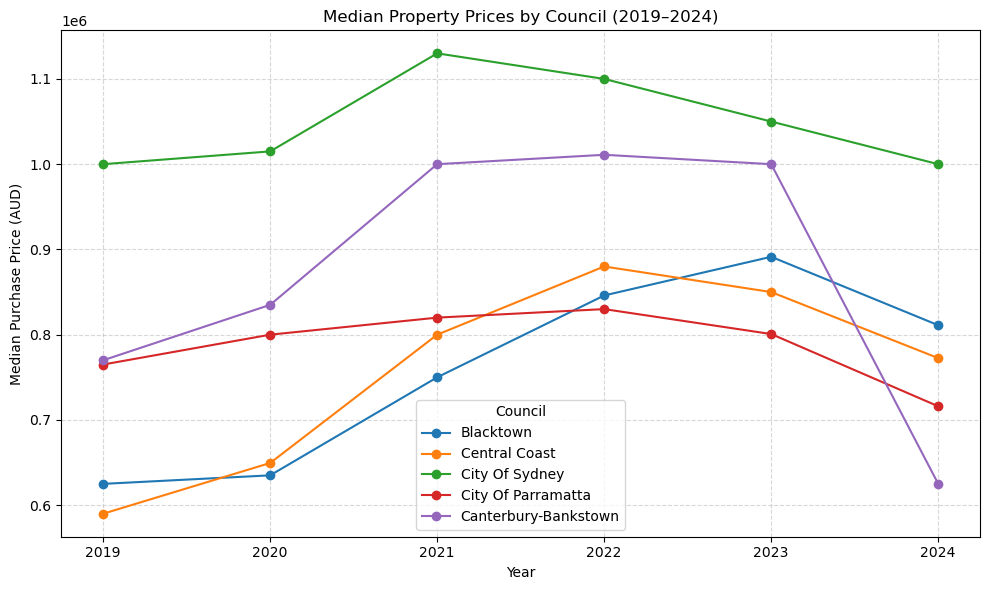

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load cleaned data ---
df = pd.read_csv("nsw_affordability_core_2019_2024.csv", parse_dates=["contract_date"])

# Safety: ensure helper year column exists
if "contract_year" not in df.columns:
    df["contract_year"] = df["contract_date"].dt.year

# Keep sensible rows
df = df.dropna(subset=["purchase_price", "council_name", "contract_year"])

# --- Pick councils with most transactions to keep the chart readable ---
top_councils = (
    df["council_name"]
    .value_counts()
    .head(5)
    .index
    .tolist()
)

# --- Median purchase price by year & council ---
median_prices = (
    df[df["council_name"].isin(top_councils)]
    .groupby(["contract_year", "council_name"])["purchase_price"]
    .median()
    .reset_index()
    .sort_values(["council_name", "contract_year"])
)

# --- Plot ---
plt.figure(figsize=(10, 6))
for council in top_councils:
    cdat = median_prices[median_prices["council_name"] == council]
    plt.plot(cdat["contract_year"], cdat["purchase_price"], marker="o", label=council)

plt.title("Median Property Prices by Council (2019–2024)")
plt.xlabel("Year")
plt.ylabel("Median Purchase Price (AUD)")
plt.legend(title="Council")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
#plt.savefig("SLO2_median_prices_chart.png")
#print("Saved chart -> SLO2_median_prices_chart.png")


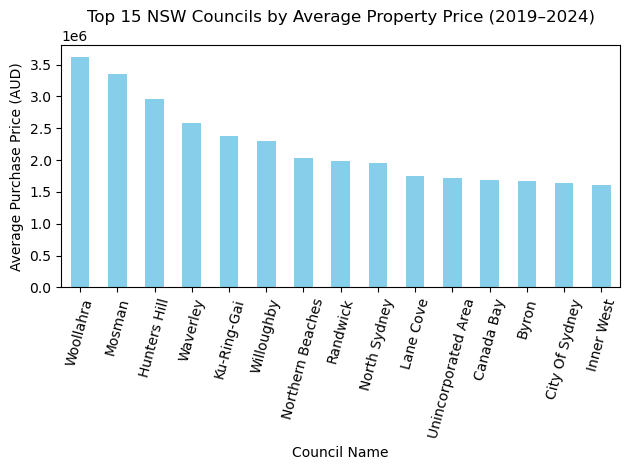

In [6]:
import pandas as pd
#import geopandas as gpd
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv("nsw_affordability_core_2019_2024.csv")

# Calculate average price by council
avg_price_by_council = (
    df.groupby("council_name")["purchase_price"]
    .mean()
    .reset_index()
    .rename(columns={"purchase_price": "avg_price"})
)

avg_price_by_council.sort_values("avg_price", ascending=False).head(15).plot(
    kind="bar", x="council_name", y="avg_price", legend=False, color="skyblue"
)
plt.xticks(rotation=75)
plt.ylabel("Average Purchase Price (AUD)")
plt.xlabel("Council Name")
plt.title("Top 15 NSW Councils by Average Property Price (2019–2024)")
plt.tight_layout()
plt.show()
#plt.savefig("SLO2_avg_price_heatmap_placeholder.png")


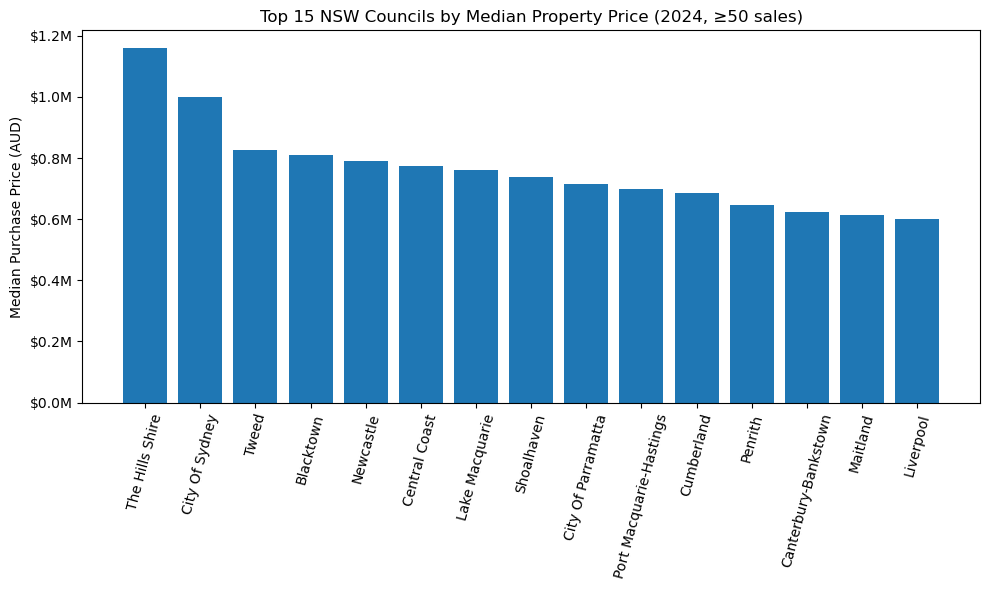

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df = pd.read_csv("nsw_affordability_core_2019_2024.csv", parse_dates=["contract_date"])
if "contract_year" not in df.columns:
    df["contract_year"] = df["contract_date"].dt.year

# 1) 2024 medians by council, require ≥50 sales
y = 2024
cy = (df[df["contract_year"] == y]
      .groupby("council_name")["purchase_price"]
      .median().reset_index(name="median_price"))
vol = (df[df["contract_year"] == y]
       .groupby("council_name").size().reset_index(name="n_txn"))
t2024 = (cy.merge(vol, on="council_name")
           .query("n_txn >= 50")
           .sort_values("median_price", ascending=False)
           .head(15))

# Plot (medians)
plt.figure(figsize=(10,6))
plt.bar(t2024["council_name"], t2024["median_price"])
plt.xticks(rotation=75)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x,_: f"${x/1e6:.1f}M"))
plt.ylabel("Median Purchase Price (AUD)")
plt.title(f"Top 15 NSW Councils by Median Property Price ({y}, ≥50 sales)")
plt.tight_layout()
plt.show()
#plt.savefig("top15_2024_median.png", dpi=150)
#print("Saved -> top15_2024_median.png")


In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv("nsw_affordability_core_2019_2024.csv", parse_dates=["contract_date"])
if "contract_year" not in df.columns:
    df["contract_year"] = df["contract_date"].dt.year

df = df.dropna(subset=["purchase_price", "council_name", "contract_year"])
df = df[(df["contract_year"] >= 2019) & (df["contract_year"] <= 2024)]

# Council–year medians and volumes
agg = (df.groupby(["council_name","contract_year"])["purchase_price"]
         .median().reset_index(name="median_price"))
vol = (df.groupby(["council_name","contract_year"])
         .size().reset_index(name="n_txn"))
coy = agg.merge(vol, on=["council_name","contract_year"], how="left")

# 2019 & 2024 slices with stability filter (≥50 sales both years)
c2019 = coy.query("contract_year == 2019 & n_txn >= 50")[["council_name","median_price"]].rename(columns={"median_price":"m2019"})
c2024 = coy.query("contract_year == 2024 & n_txn >= 50")[["council_name","median_price"]].rename(columns={"median_price":"m2024"})

g = c2019.merge(c2024, on="council_name", how="inner").dropna()
g = g[g["m2019"] > 0].copy()

# Growth metrics
g["total_growth"] = (g["m2024"] / g["m2019"]) - 1
g["cagr"] = (g["m2024"] / g["m2019"])**(1/5) - 1

# Add percentage columns (name can include % when set like this)
g["total_growth_%"] = (g["total_growth"]*100).round(1)
g["cagr_%"] = (g["cagr"]*100).round(1)

fastest = g.sort_values("cagr", ascending=False)

print(fastest.head(15)[["council_name","m2019","m2024","total_growth_%","cagr_%"]].to_string(index=False))


           council_name     m2019     m2024  total_growth_%  cagr_%
            Wagga Wagga  330000.0  567500.0            72.0    11.5
               Maitland  410500.0  615000.0            49.8     8.4
                  Tweed  560000.0  825000.0            47.3     8.1
Port Macquarie-Hastings  484000.0  700000.0            44.6     7.7
              Mid-Coast  395000.0  570000.0            44.3     7.6
             Shoalhaven  520000.0  737500.0            41.8     7.2
         Lake Macquarie  545000.0  761000.0            39.6     6.9
              Newcastle  585000.0  790000.0            35.0     6.2
          Central Coast  590000.0  772500.0            30.9     5.5
              Blacktown  625000.0  811088.0            29.8     5.4
        The Hills Shire  940000.0 1160000.0            23.4     4.3
                Penrith  600000.0  645000.0             7.5     1.5
             Cumberland  650979.0  687000.0             5.5     1.1
         City Of Sydney 1000000.0 1000000.0     

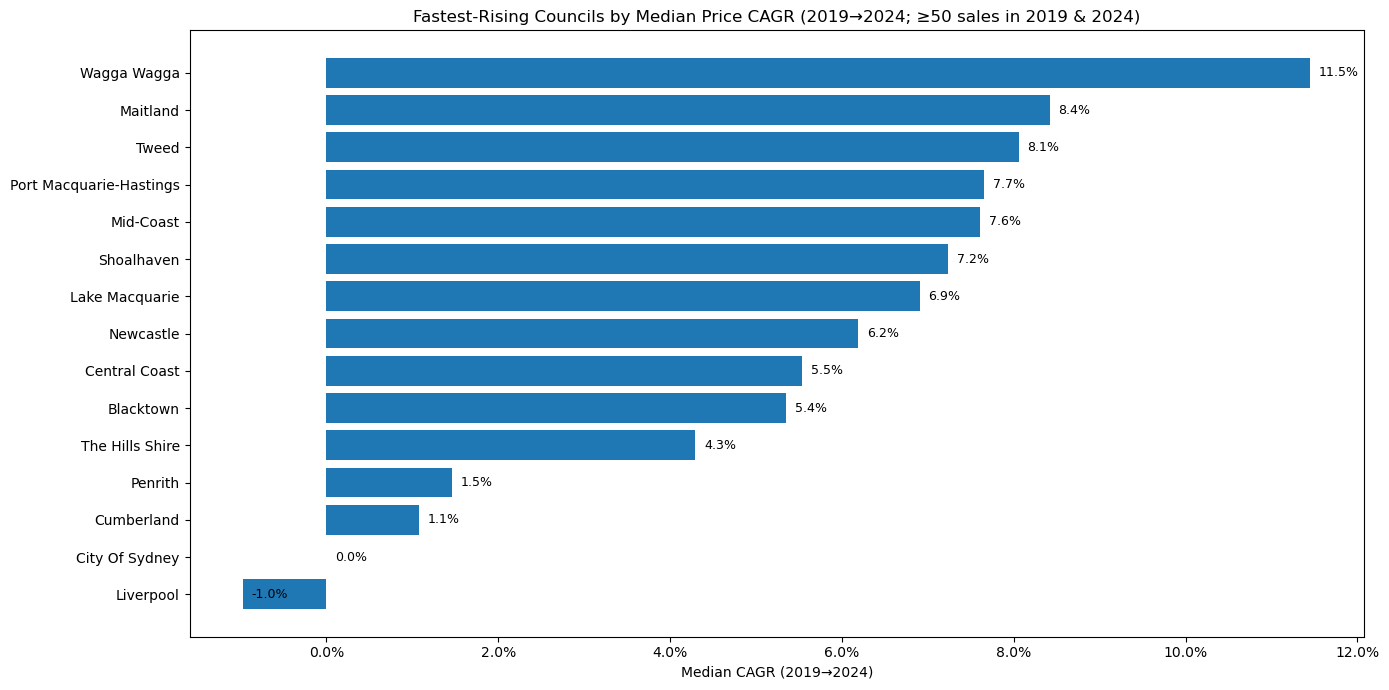

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Use your existing `fastest` (sorted by 'cagr' desc) or make it:
# fastest = g.sort_values("cagr", ascending=False)

top = fastest.head(15).copy().sort_values("cagr")  # small→large for a tidy barh

plt.figure(figsize=(14, 7))
ax = plt.gca()
bars = ax.barh(top["council_name"], top["cagr"])

# Format x-axis as percent
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Median CAGR (2019→2024)")
ax.set_title("Fastest-Rising Councils by Median Price CAGR (2019→2024; ≥50 sales in 2019 & 2024)")

# Annotate each bar with its % value
for bar in bars:
    w = bar.get_width()
    y = bar.get_y() + bar.get_height()/2
    ax.text(w + 0.001, y, f"{w*100:.1f}%", va="center", ha="left", fontsize=9)

plt.tight_layout()
plt.show()
# plt.savefig("fastest_risers_cagr_bar.png", dpi=220)


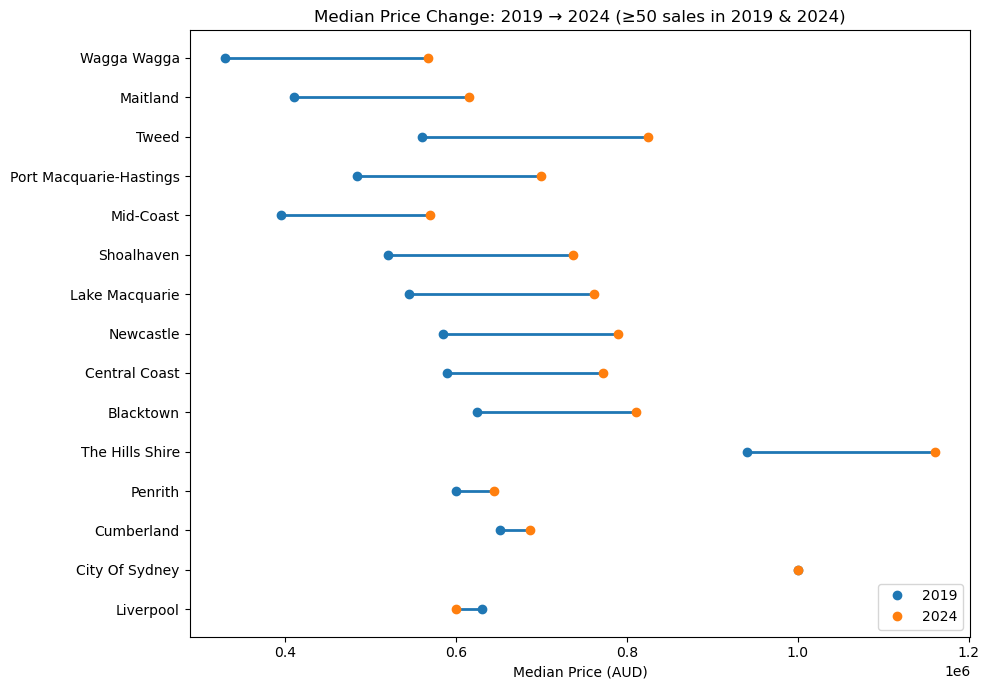

In [10]:
import numpy as np
import matplotlib.pyplot as plt

sel = fastest.head(15).copy().sort_values("cagr")  # same selection/order
y = np.arange(len(sel))

plt.figure(figsize=(10, 7))
ax = plt.gca()

# Lines between 2019 and 2024 medians
ax.hlines(y=y, xmin=sel["m2019"], xmax=sel["m2024"], linewidth=2)

# Endpoints
ax.plot(sel["m2019"], y, "o", label="2019")
ax.plot(sel["m2024"], y, "o", label="2024")

ax.set_yticks(y)
ax.set_yticklabels(sel["council_name"])
ax.set_xlabel("Median Price (AUD)")
ax.set_title("Median Price Change: 2019 → 2024 (≥50 sales in 2019 & 2024)")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()
# plt.savefig("fastest_risers_slope.png", dpi=220)


In [11]:
import pandas as pd
import numpy as np
from pathlib import Path

# ---- paths ----
IN = Path("nsw_property_data_cleaned_2019_onwards.csv")   # change if needed
OUT_CSV = Path("nsw_affordability_core_2019_2024.csv")

# ---- load ----
df = pd.read_csv(IN, low_memory=False, parse_dates=["contract_date"])

# ---- robust column picking (handles name variants) ----
def pick_first(cols, options):
    for o in options:
        if o in cols: return o
    return None

cols = df.columns.str.lower().tolist()
map_cols = {
    "council_name": pick_first(cols, ["council_name","lga_name","lga","council"]),
    "contract_date": pick_first(cols, ["contract_date","contracted_on","sale_date","date"]),
    "purchase_price": pick_first(cols, ["purchase_price","price","sale_price"]),
    "property_type": pick_first(cols, ["property_type","propertycategory","type","dwelling_type"]),
}
missing = [k for k,v in map_cols.items() if v is None and k in ["council_name","contract_date","purchase_price"]]
if missing:
    raise ValueError(f"Missing required column(s): {missing}\nAvailable: {df.columns.tolist()}")

# ---- minimal cleaning aligned to our value prop ----
df = df.rename(columns={v:k for k,v in map_cols.items() if v is not None})

# dates & year window
df["contract_year"] = pd.to_datetime(df["contract_date"], errors="coerce").dt.year
df = df[(df["contract_year"] >= 2019) & (df["contract_year"] <= 2024)]

# sensible price range
df["purchase_price"] = pd.to_numeric(df["purchase_price"], errors="coerce")
df = df[(df["purchase_price"] >= 10_000) & (df["purchase_price"] <= 20_000_000)]

# tidy text
df["council_name"] = df["council_name"].astype("string").str.strip().str.title()

# unify property_type to {House, Unit, Other} if present
if "property_type" in df.columns:
    t = df["property_type"].astype("string").str.lower().str.strip()
    df["property_type"] = (
        t.replace({
            "house":"house","detached":"house","freestanding":"house",
            "unit":"unit","apartment":"unit","flat":"unit","studio":"unit","townhouse":"unit",
        })
        .where(lambda s: s.isin(["house","unit"]), other="other")
        .str.title()
    )

# ---- select only what we need ----
keep = ["council_name","contract_date","contract_year","purchase_price"]
if "property_type" in df.columns: keep.append("property_type")
df_slim = df[keep].copy()

# optional in-memory downcasts (CSV on disk stays text)
df_slim["contract_year"] = df_slim["contract_year"].astype("int16")
df_slim["purchase_price"] = pd.to_numeric(df_slim["purchase_price"], downcast="integer")

# ---- quick sanity checks ----
statewide = (df_slim.groupby("contract_year")["purchase_price"]
             .median().rename("median_price").reset_index())
print("Statewide medians 2019–2024:\n", statewide.to_string(index=False))

print("\nTop 10 councils by 2024 median (preview):")
print(df_slim[df_slim["contract_year"]==2024]
      .groupby("council_name")["purchase_price"].median()
      .sort_values(ascending=False).head(10).to_string())

# ---- save CSV only ----
df_slim.to_csv(OUT_CSV, index=False)
print(f"\nSaved: {OUT_CSV}  (rows={len(df_slim)}, cols={df_slim.shape[1]})")


Statewide medians 2019–2024:
  contract_year  median_price
          2019      643500.0
          2020      649000.0
          2021      750000.0
          2022      835000.0
          2023      850000.0
          2024      686000.0

Top 10 councils by 2024 median (preview):
council_name
Bland              3047500.0
Willoughby         1555000.0
Woollahra          1450000.0
Waverley           1301000.0
The Hills Shire    1160000.0
Ku-Ring-Gai        1100000.0
Randwick           1085000.0
North Sydney       1030000.0
City Of Sydney     1000000.0
Sutherland          990000.0

Saved: nsw_affordability_core_2019_2024.csv  (rows=947407, cols=5)


In [12]:
distinct_col = np.unique(df["council_name"])
print(f"Distinct councils in cleaned data: {distinct_col}")

Distinct councils in cleaned data: ['024' '039' '044' '069' '086' '089' '091' '093' '134' '135' '141' '142'
 '203' '205' '206' '208' '221' 'Albury' 'Armidale Regional' 'Ballina'
 'Balranald' 'Bathurst Regional' 'Bayside' 'Bega Valley' 'Bellingen'
 'Berrigan' 'Blacktown' 'Bland' 'Blayney' 'Blue Mountains' 'Bogan'
 'Bourke' 'Brewarrina' 'Broken Hill' 'Burwood' 'Byron' 'Cabonne' 'Camden'
 'Campbelltown' 'Canada Bay' 'Canterbury-Bankstown' 'Carrathool'
 'Central Coast' 'Central Darling' 'Cessnock' 'City Of Parramatta'
 'City Of Sydney' 'Clarence Valley' 'Cobar' 'Coffs Harbour' 'Coolamon'
 'Coonamble' 'Cootamundra-Gundagai Regional' 'Cowra' 'Cumberland'
 'Dubbo Regional' 'Dungog' 'Edward River' 'Eurobodalla' 'Fairfield'
 'Federation' 'Forbes' 'Georges River' 'Gilgandra' 'Glen Innes Severn'
 'Goulburn Mulwaree' 'Greater Hume' 'Griffith' 'Gunnedah' 'Gwydir'
 'Hawkesbury' 'Hay' 'Hilltops' 'Hornsby' 'Hunters Hill' 'Inner West'
 'Inverell' 'Junee' 'Kempsey' 'Kiama' 'Ku-Ring-Gai' 'Kyogle' 'Lachla

In [13]:
distinct_houses = np.unique(df["property_type"])
print(f"Distinct house types in cleaned data: {distinct_houses}")

Distinct house types in cleaned data: ['House' 'Unit']


Unmatched after fixes: 5  (see unmatched_lga_2019_2024.csv)
Saved NSW map -> NSW_median_price_by_council_2019_2024.png
Saved CBD zoom -> CBD_zoom.png
Saved CBD labeled -> CBD_zoom_labeled.png


<Figure size 1200x900 with 0 Axes>

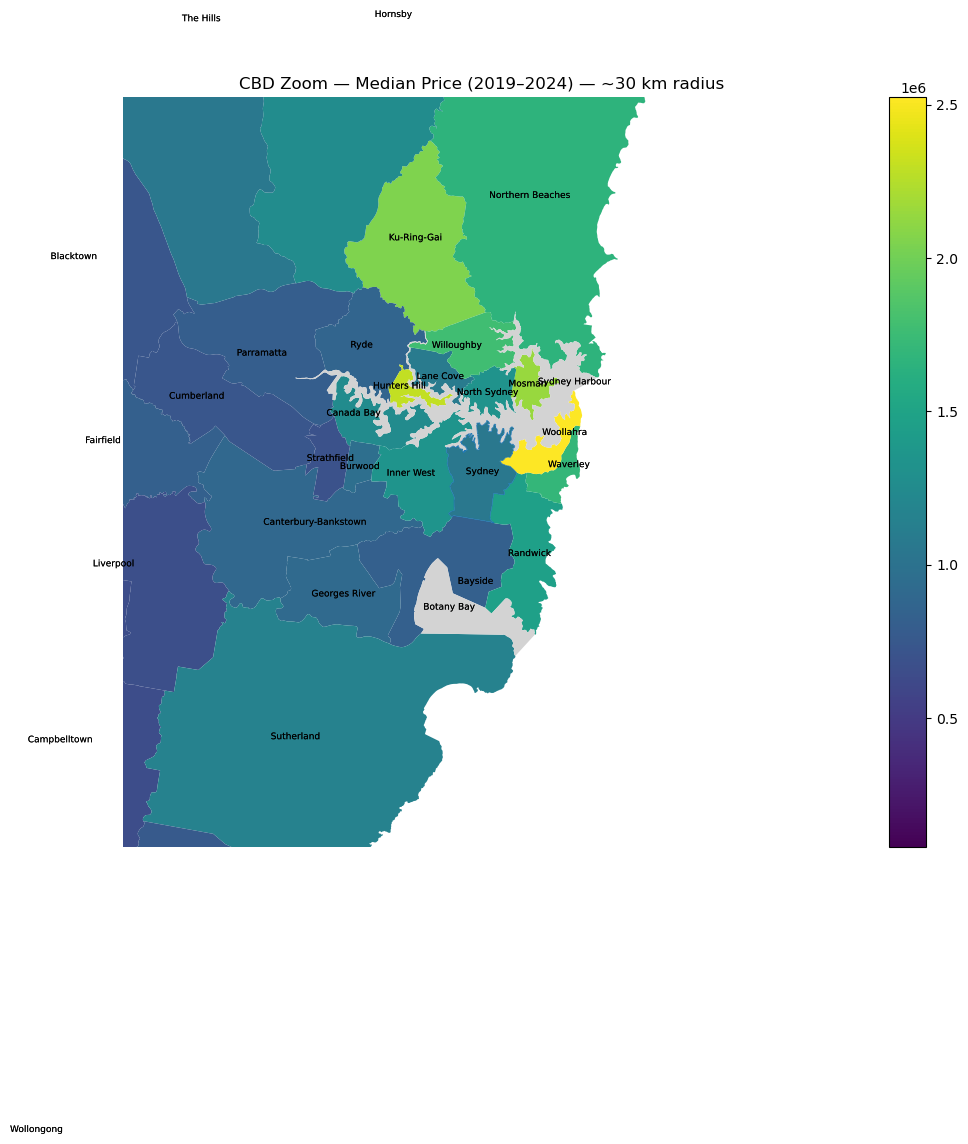

In [14]:
# make_affordability_maps.py
import os, re
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import matplotlib.patheffects as pe

CSV = Path("nsw_affordability_core_2019_2024.csv")
SHP = Path("nsw_lga.shp")           # must sit with .shx, .dbf, .prj

# helps gdal rebuild the .shx index if missing
os.environ["SHAPE_RESTORE_SHX"] = "YES"

def std(s: str) -> str:
    """Standardise council/LGA names on both sides."""
    s = str(s).replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s, flags=re.I).strip()
    s = re.sub(r"(?i)\bcity of\b", "", s)
    s = re.sub(r"(?i)\bof the\b", "", s)
    s = re.sub(r"(?i)\b(city council|regional council|municipal council|shire council|council|regional|city|shire)\b", "", s)
    return re.sub(r"\s+", " ", s).strip().title()

# a few common NSW name fixes (add more if your unmatched CSV shows any)
FIX = {
    "City Of Sydney":"Sydney","Of The Sydney":"Sydney",
    "Inner West Council":"Inner West","Randwick City Council":"Randwick",
    "North Sydney Council":"North Sydney","Woollahra Council":"Woollahra",
    "Waverley Council":"Waverley","Canada Bay Council":"Canada Bay",
    "Bayside Council":"Bayside","Mosman Council":"Mosman",
    "Lane Cove Council":"Lane Cove","Willoughby City Council":"Willoughby",
    "Cumberland City Council":"Cumberland","Strathfield Municipal Council":"Strathfield",
    "City Of Ryde":"Ryde","City Of Parramatta":"Parramatta",
    "The Hills Shire Council":"The Hills Shire","Hornsby Shire Council":"Hornsby Shire",
    "Sutherland Shire Council":"Sutherland Shire",
    "Blacktown City Council":"Blacktown","City Of Liverpool":"Liverpool","City Of Penrith":"Penrith","The Of Hornsby":"Hornsby",
    "City Of Campbelltown":"Campbelltown","Georges River Council":"Georges River",
    "City Of Canterbury-Bankstown":"Canterbury-Bankstown","Canterbury-Bankstown Council":"Canterbury-Bankstown","Unincorporated - Botany Bay Area":"Botany Bay",
    "Unincorporated - Sydney Harbour Area":"Sydney Harbour", "The Municipality Of Hunters Hill":"Hunters Hill",
    "Central Coast Council":"Central Coast","The Municipality Of Kiama":"Kiama",
    "Port Macquarie-Hastings Council":"Port Macquarie-Hastings","Mid-Coast Council":"Mid-Coast",
    "Coffs Harbour City Council":"Coffs Harbour","Byron Shire Council":"Byron",
    "Ballina Shire Council":"Ballina","Tweed Shire Council":"Tweed  ",
    "Bega Valley Shire Council":"Bega Valley","Kempsey Shire Council":"Kempsey",
    "Queanbeyan-Palerang Regional Council":"Queanbeyan-Palerang Regional","Mid-Western":"Mid Western Regional", "Nambucca Valley":"Nambucca"
}

# ---------- load slim CSV ----------
df = pd.read_csv(CSV, parse_dates=["contract_date"])
if "contract_year" not in df.columns:
    df["contract_year"] = df["contract_date"].dt.year

# standardise names
df["council_name_std"] = df["council_name"].map(std).replace(FIX)

# 2019–2024 median price by council
med = (df.groupby("council_name_std")["purchase_price"]
         .median().reset_index(name="median_price_2019_2024"))

# ---------- load shapefile ----------
gdf = gpd.read_file(SHP)
name_col = next((c for c in ["Lga_name","LGA_NAME","LGA_NAME21","LGA_NAME20","NSW_LGA","NAME","NAME_1"]
                 if c in gdf.columns), gdf.columns[0])
gdf["lga_name_std"] = gdf[name_col].map(std).replace(FIX)

# join prices to shapes
g_all = gdf.merge(med, left_on="lga_name_std", right_on="council_name_std", how="left")

# report any names that still didn’t join (so you can add to FIX and re-run)
unmatched = g_all[g_all["median_price_2019_2024"].isna()][["lga_name_std"]].drop_duplicates()
unmatched.to_csv("unmatched_lga_2019_2024.csv", index=False)
print(f"Unmatched after fixes: {len(unmatched)}  (see unmatched_lga_2019_2024.csv)")

# ---------- MAP 1: NSW (2019–2024 median) ----------
plt.figure(figsize=(12, 9))
g_all.plot(column="median_price_2019_2024", legend=True,
           missing_kwds={"color":"lightgrey","label":"No data"})
plt.title("NSW – Median Property Price by Council (2019–2024)")
plt.axis("off"); plt.tight_layout()
plt.savefig("NSW_median_price_by_council_2019_2024.png", dpi=180); plt.close()
print("Saved NSW map -> NSW_median_price_by_council_2019_2024.png")

# ---------- MAP 2: CBD zoom (meters-based buffer) ----------
# project to meters for a distance-based zoom box
g_all_m = g_all.to_crs(epsg=3857)
syd_m = g_all_m[g_all_m["lga_name_std"] == "Sydney"]
if syd_m.empty:
    raise ValueError("Could not find 'Sydney' polygon. Add a FIX entry for its name and re-run.")

# change buffer to control zoom tightness (in meters): 3000 tight, 8000 wider
buffer_m = 30000
bbox = syd_m.geometry.buffer(buffer_m).total_bounds
minx, miny, maxx, maxy = bbox

# plot clipped extent
ax = g_all_m.plot(column="median_price_2019_2024", legend=True, figsize=(10,8),
                  missing_kwds={"color":"lightgrey","label":"No data"})
ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
ax.set_title(f"CBD Zoom — Median Price (2019–2024) — ~{buffer_m/1000:.0f} km radius")
ax.axis("off"); plt.tight_layout()
plt.savefig("CBD_zoom.png", dpi=220)
print("Saved CBD zoom -> CBD_zoom.png")

# ---------- optional: label councils only inside the zoom ----------
clip_poly = box(minx, miny, maxx, maxy)
g_clip = g_all_m[g_all_m.geometry.intersects(clip_poly)].copy()

for _, r in g_clip.iterrows():
    c = r.geometry.representative_point()
    plt.text(c.x, c.y, r["lga_name_std"], fontsize=6.5, ha="center", va="center",
             path_effects=[pe.withStroke(linewidth=0, foreground="black")])

# emphasise City of Sydney boundary
g_clip[g_clip["lga_name_std"]=="Sydney"].boundary.plot(ax=ax, linewidth=0.5)

plt.savefig("CBD_zoom_labeled.png", dpi=470)
print("Saved CBD labeled -> CBD_zoom_labeled.png")



C:\Users\shrey\AppData\Local\Temp\ipykernel_18404\3078798064.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  syd_union = syd_m.geometry.unary_union


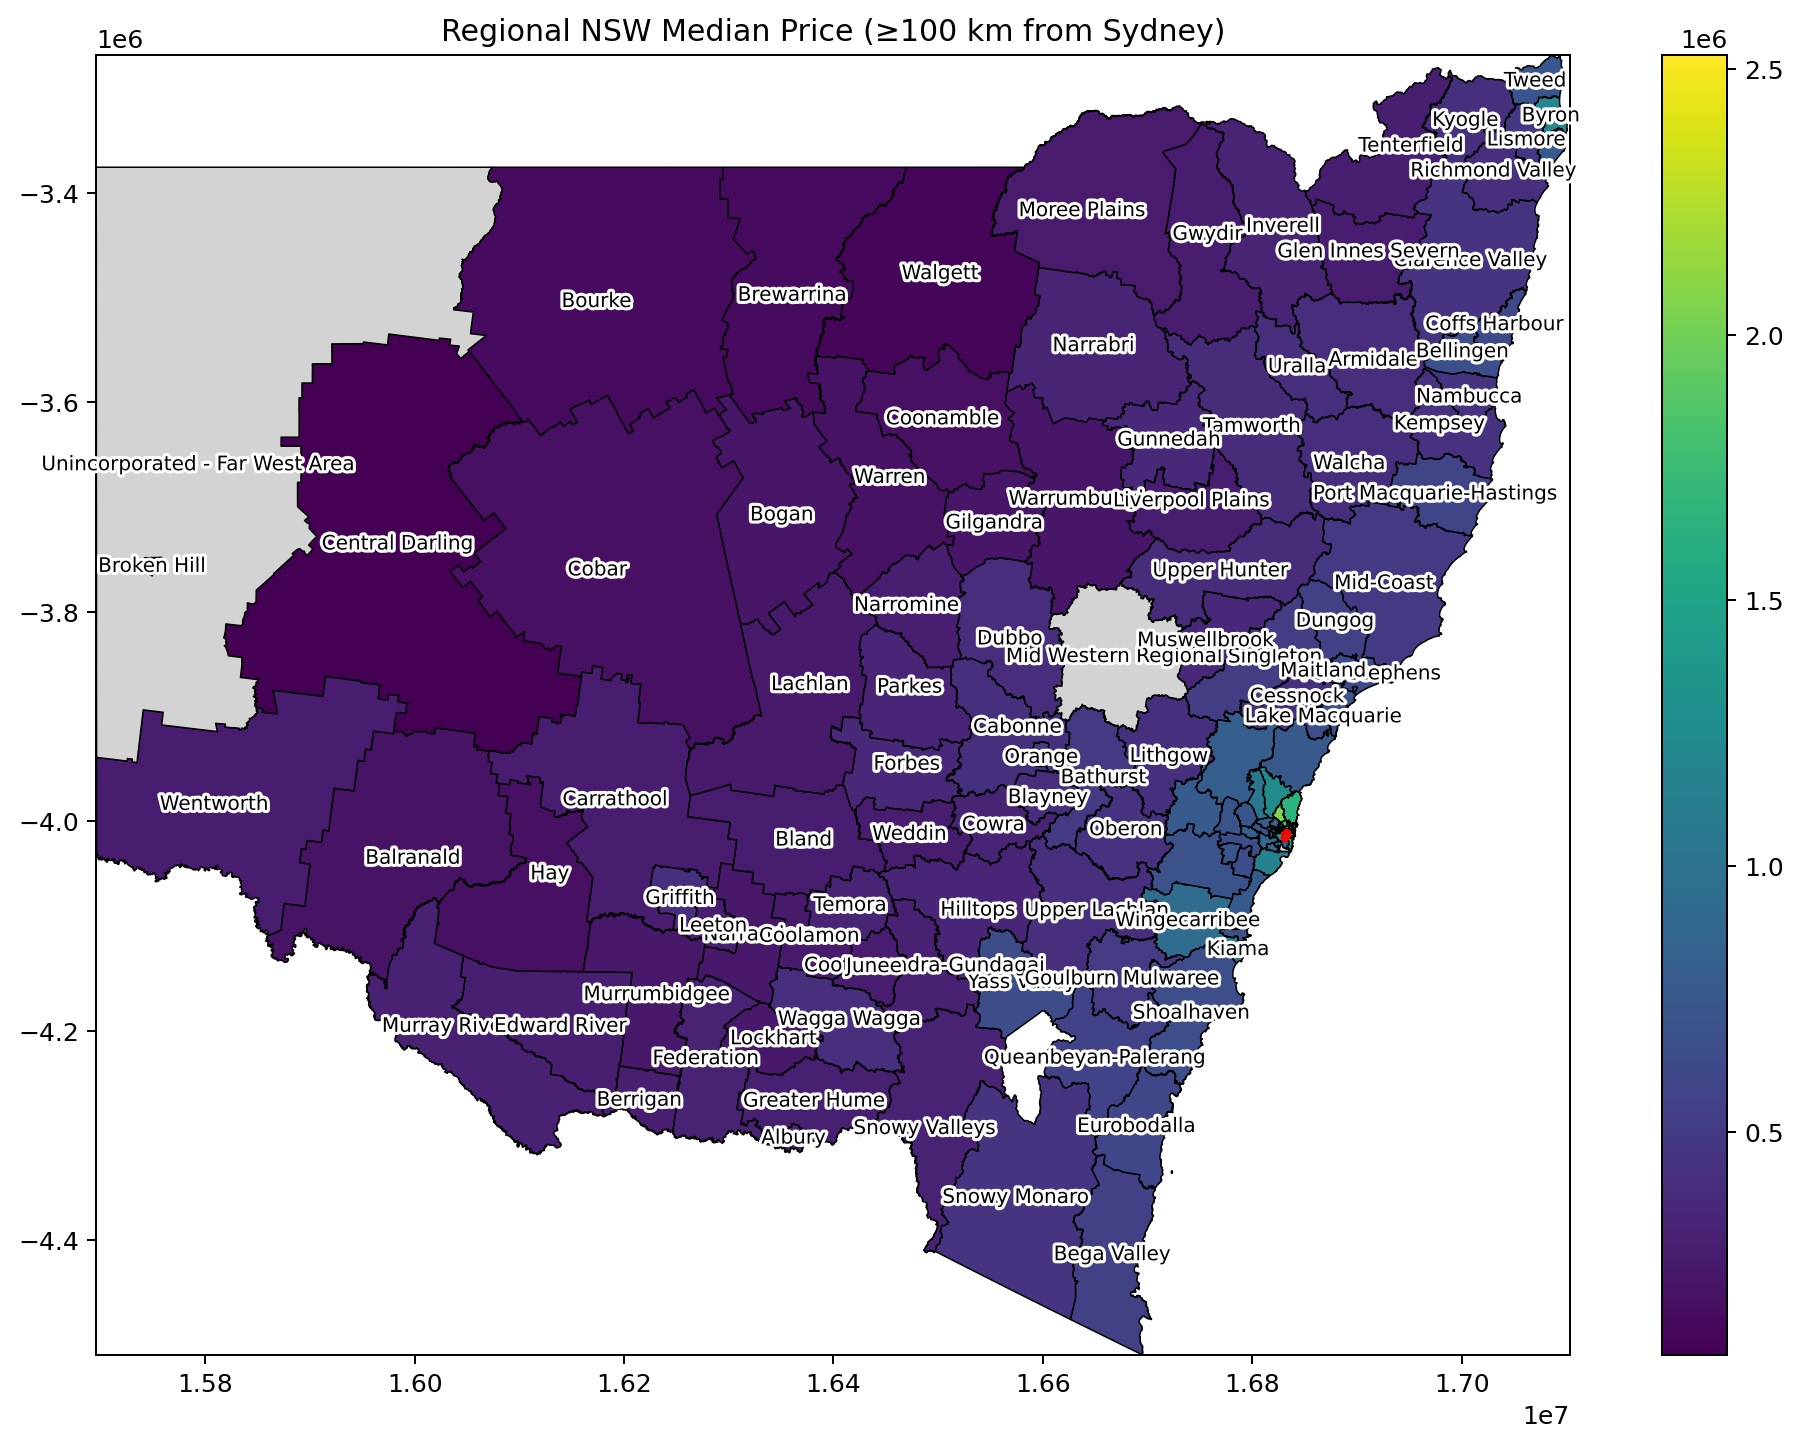

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# -------- TWEAKABLES --------
REGIONAL_KM = 100          # label councils at least this far from Sydney
MIN_LABEL_SPACING_KM = 30  # keep at least this distance between labels
MIN_AREA_SQ_KM = 150       # don't label tiny polygons
FONT_SIZE = 8
# ----------------------------

# Assumes:
# - g_all_m : NSW LGAs in EPSG:3857 (meters)
# - syd_m   : City of Sydney polygon (same CRS)

# 0) Prep & exclusions (e.g., Lord Howe Island)
mainland = g_all_m[~g_all_m["lga_name_std"].str.contains("Lord Howe", case=False, na=False)].copy()

# 1) Sydney reference points
syd_union = syd_m.geometry.unary_union
syd_centroid = syd_union.centroid

# 2) Representative points (safer than pure centroids)
mainland["_pt"] = mainland.geometry.representative_point()

# 3) Distances & areas
mainland["_dist_m"] = mainland["_pt"].distance(syd_centroid)
mainland["_area_m2"] = mainland.geometry.area

# 4) Regional filter: far enough and reasonably large
regional = mainland[
    (mainland["_dist_m"] >= REGIONAL_KM * 1000) &
    (mainland["_area_m2"] >= MIN_AREA_SQ_KM * 1_000_000)
].copy()

# 5) Greedy spacing: prefer bigger areas; keep labels >= MIN_LABEL_SPACING_KM apart
regional = regional.sort_values("_area_m2", ascending=False)
selected_idx, selected_pts = [], []
for idx, row in regional.iterrows():
    pt = row["_pt"]
    if all(pt.distance(other) >= MIN_LABEL_SPACING_KM * 1000 for other in selected_pts):
        selected_idx.append(idx)
        selected_pts.append(pt)

labels_df = regional.loc[selected_idx]

# 6) Plot
fig, ax = plt.subplots(figsize=(11, 8), dpi=180)

# Base map
mainland.plot(
    ax=ax,
    column="median_price_2019_2024",
    legend=True,
    edgecolor="black",
    linewidth=0.6,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# Outline City of Sydney (context)
syd_m.boundary.plot(ax=ax, color="red", linewidth=1.2)

# Labels with white halo for readability
for (x, y), label in zip(labels_df["_pt"].apply(lambda g: (g.x, g.y)), labels_df["lga_name_std"]):
    t = ax.text(x, y, label, fontsize=FONT_SIZE, ha="center", va="center")
    t.set_path_effects([pe.withStroke(linewidth=2.5, foreground="white")])

# Keep view to mainland bounds (avoids offshore dragging the canvas)
xmin, ymin, xmax, ymax = mainland.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title(f"Regional NSW Median Price (≥{REGIONAL_KM} km from Sydney)")
plt.tight_layout()
plt.show()


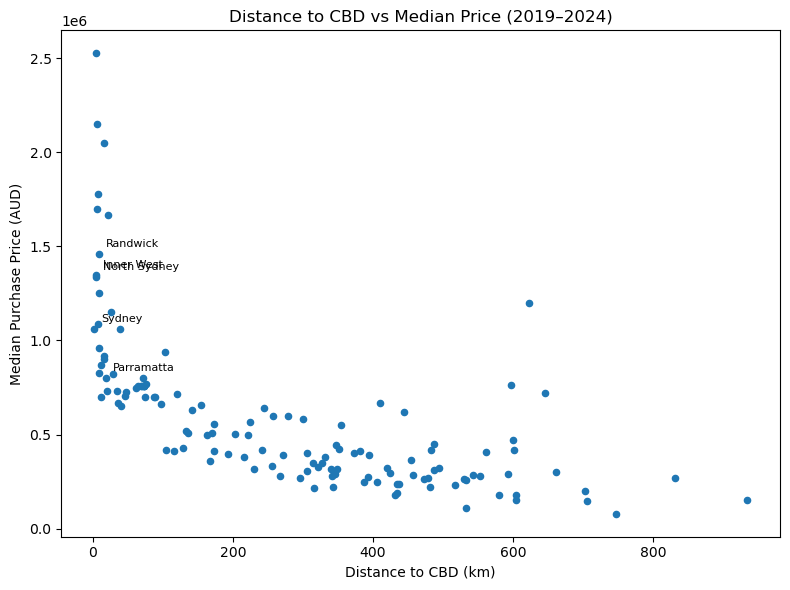

In [16]:
import pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
from pyproj import Geod
import re

CSV = "nsw_affordability_core_2019_2024.csv"
SHP = "nsw_lga.shp"

def std(s):
    s = str(s).replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s, flags=re.I).strip()
    s = re.sub(r"(?i)\bcity of\b", "", s); s = re.sub(r"(?i)\bof the\b", "", s)
    s = re.sub(r"(?i)\b(city council|regional council|municipal council|shire council|council|regional|city|shire)\b", "", s)
    return re.sub(r"\s+", " ", s).strip().title()

# --- load ---
df = pd.read_csv(CSV, parse_dates=["contract_date"])
gdf = gpd.read_file(SHP)

df["council_name_std"] = df["council_name"].map(std)
name_col = next((c for c in ["Lga_name","LGA_NAME","NSW_LGA","NAME","NAME_1"] if c in gdf.columns), gdf.columns[0])
gdf["lga_name_std"] = gdf[name_col].map(std)

# --- medians ---
med = df.groupby("council_name_std")["purchase_price"].median().reset_index(name="median_2019_2024")

# --- CORRECT way: centroid in a projected CRS, then back to WGS84 ---
gdf_m = gdf.to_crs(epsg=3857).copy()                 # meters (Web Mercator). For AU-wide, EPSG:3577 also good.
gdf_m["centroid_m"] = gdf_m.geometry.centroid        # safe: planar centroid
centroids_wgs = gpd.GeoSeries(gdf_m["centroid_m"], crs=3857).to_crs(epsg=4326)

gdf_wgs = gdf.to_crs(epsg=4326).copy()
gdf_wgs["centroid"] = centroids_wgs                  # now centroids in lon/lat

# --- geodesic distance to CBD (Sydney Town Hall) ---
CBD_LAT, CBD_LON = -33.8730, 151.2060
geod = Geod(ellps="WGS84")
def dist_km(pt):
    lon, lat = pt.x, pt.y
    _, _, d = geod.inv(CBD_LON, CBD_LAT, lon, lat)
    return d / 1000.0

gdf_wgs["distance_km"] = gdf_wgs["centroid"].apply(dist_km)

# --- join and plot ---
X = gdf_wgs.merge(med, left_on="lga_name_std", right_on="council_name_std", how="left")
ax = X.plot.scatter(x="distance_km", y="median_2019_2024", figsize=(8,6))
plt.title("Distance to CBD vs Median Price (2019–2024)")
plt.xlabel("Distance to CBD (km)")
plt.ylabel("Median Purchase Price (AUD)")

# annotate a few key councils
for _, r in X[X["lga_name_std"].isin(["Sydney","North Sydney","Inner West","Parramatta","The Hills Shire","Randwick"])].iterrows():
    plt.annotate(r["lga_name_std"], (r["distance_km"], r["median_2019_2024"]),
                 xytext=(5,5), textcoords="offset points", fontsize=8)

plt.tight_layout();
plt.show() 
#plt.savefig("distance_vs_price_scatter.png", dpi=200); plt.close()


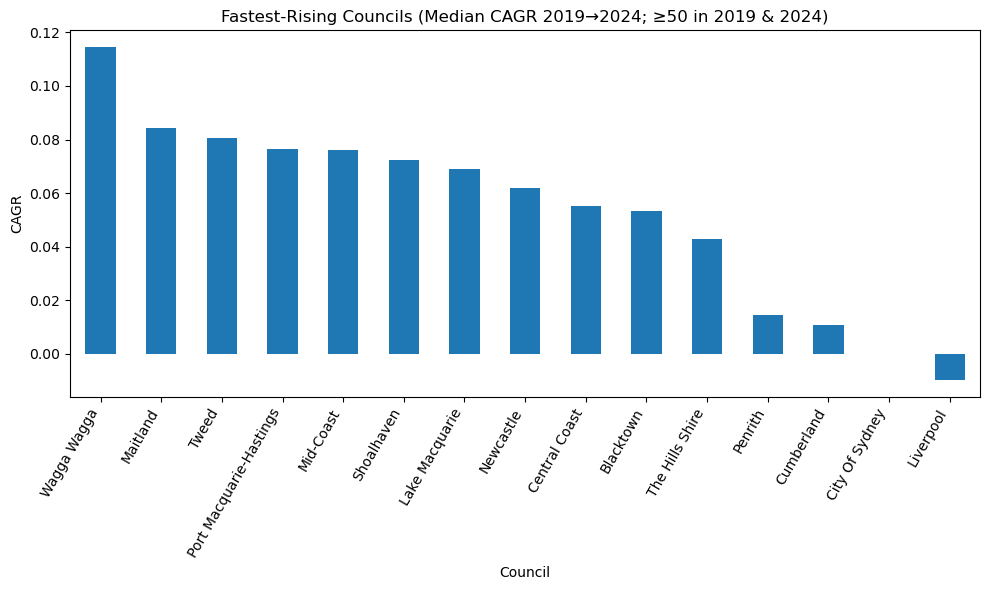

In [17]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.read_csv("nsw_affordability_core_2019_2024.csv", parse_dates=["contract_date"])
if "contract_year" not in df.columns:
    df["contract_year"] = df["contract_date"].dt.year
df["council_name_std"] = df["council_name"].str.title()

# Top-2024 (stability rule)
d2024 = df[df["contract_year"]==2024]
vol2024 = d2024.groupby("council_name_std").size().rename("n").reset_index()
med2024 = d2024.groupby("council_name_std")["purchase_price"].median().reset_index()
top2024 = (med2024.merge(vol2024, on="council_name_std")
                    .query("n >= 50")
                    .sort_values("purchase_price", ascending=False)
                    .head(15))
ax = top2024.plot(kind="bar", x="council_name_std", y="purchase_price", legend=False, figsize=(10,6))
plt.title("Top Councils by 2024 Median (≥50 sales)")
plt.xlabel("Council"); plt.ylabel("Median Purchase Price (AUD)")
plt.xticks(rotation=60, ha="right"); plt.tight_layout(); plt.savefig("top_2024_median_bar.png", dpi=200); plt.close()

# CAGR leaderboard (2019→2024, ≥50 in both years)
def year_stats(y):
    d = df[df["contract_year"]==y]
    return (d.groupby("council_name_std")["purchase_price"].median()
              .rename(f"med_{y}").to_frame()
              .join(d.groupby("council_name_std").size().rename(f"n_{y}")))

m2019 = year_stats(2019); m2024 = year_stats(2024)
g = m2019.join(m2024, how="inner")
g = g[(g["n_2019"]>=50) & (g["n_2024"]>=50)].copy()
g["CAGR"] = (g["med_2024"]/g["med_2019"])**(1/5) - 1  # 5-year span
lead = g.sort_values("CAGR", ascending=False).head(15).reset_index()

ax = lead.plot(kind="bar", x="council_name_std", y="CAGR", legend=False, figsize=(10,6))
plt.title("Fastest-Rising Councils (Median CAGR 2019→2024; ≥50 in 2019 & 2024)")
plt.xlabel("Council"); plt.ylabel("CAGR")
plt.xticks(rotation=60, ha="right"); plt.tight_layout(); 
plt.show()
#plt.savefig("fastest_risers_cagr.png", dpi=200); plt.close()


C:\Users\shrey\AppData\Local\Temp\ipykernel_18404\1262553613.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["distance_band","property_type"])["median_2019_2024"]


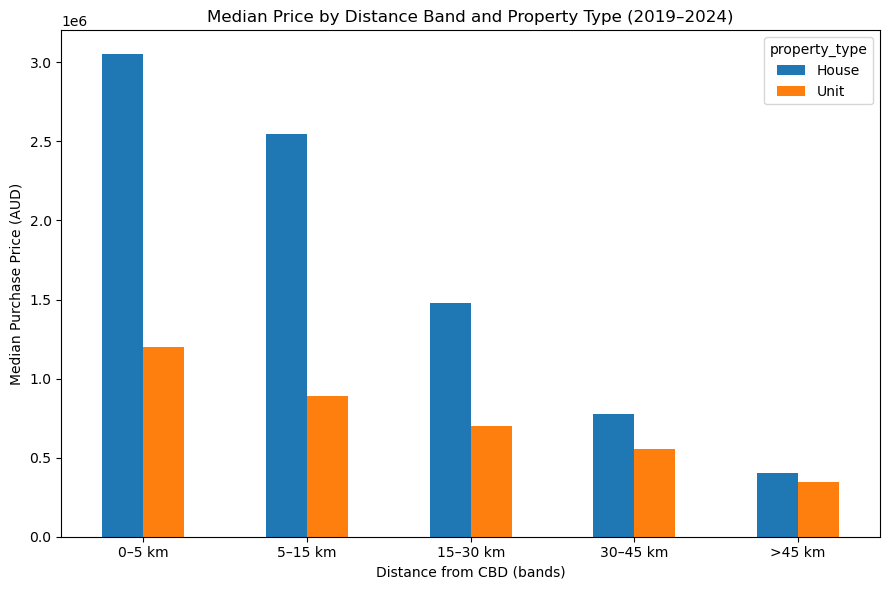

Saved: house_unit_by_distance_band.png, house_unit_by_distance_band_evidence.csv, lga_distance_to_cbd.csv


In [18]:
# make_house_unit_by_distance_bands.py
import os, re
from pathlib import Path
import pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
from pyproj import Geod

CSV_CANDIDATES = [
    "nsw_affordability_core_2019_2024.csv",
    "nsw_property_data_cleaned_2019_onwards.csv",
    "nsw_property_data_2019_onwards.csv",
]
SHP = Path("nsw_lga.shp")

# If pyogrio/fiona has trouble with .shx, let GDAL rebuild it
os.environ["SHAPE_RESTORE_SHX"] = "YES"

def std(s: str) -> str:
    s = str(s).replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s, flags=re.I).strip()
    s = re.sub(r"(?i)\bcity of\b", "", s); s = re.sub(r"(?i)\bof the\b", "", s)
    s = re.sub(r"(?i)\b(city council|regional council|municipal council|shire council|council|regional|city|shire)\b", "", s)
    return re.sub(r"\s+", " ", s).strip().title()

# -------- load CSV (pick the first that exists) --------
CSV = next((p for p in CSV_CANDIDATES if Path(p).exists()), None)
if not CSV:
    raise FileNotFoundError("Could not find any CSV: " + ", ".join(CSV_CANDIDATES))
df = pd.read_csv(CSV, low_memory=False, parse_dates=["contract_date"] if "contract_date" in pd.read_csv(CSV, nrows=1).columns else None)

# ensure column names we need
if "council_name" not in df.columns:
    for alt in ["lga_name","lga","council"]:
        if alt in df.columns: df = df.rename(columns={alt:"council_name"}); break
if "purchase_price" not in df.columns:
    for alt in ["price","sale_price"]:
        if alt in df.columns: df = df.rename(columns={alt:"purchase_price"}); break
if "contract_year" not in df.columns:
    df["contract_year"] = pd.to_datetime(df.get("contract_date"), errors="coerce").dt.year

# filter & clean
df = df.dropna(subset=["purchase_price","council_name"])
df["purchase_price"] = pd.to_numeric(df["purchase_price"], errors="coerce")
df = df[(df["contract_year"] >= 2019) & (df["contract_year"] <= 2024)]
df = df[(df["purchase_price"] >= 10_000) & (df["purchase_price"] <= 20_000_000)]
df["council_name_std"] = df["council_name"].map(std)

# property_type guard
if "property_type" not in df.columns:
    df["property_type"] = "All"
else:
    t = df["property_type"].astype("string").str.lower().str.strip()
    df["property_type"] = (
        t.replace({
            "house":"house","detached":"house","freestanding":"house",
            "unit":"unit","apartment":"unit","flat":"unit","studio":"unit","townhouse":"unit",
        })
        .where(lambda s: s.isin(["house","unit"]), other="other")
        .str.title()
    )

# 2019–2024 medians by council × type
med = (df.groupby(["council_name_std","property_type"])["purchase_price"]
         .median().reset_index(name="median_2019_2024"))

# -------- load shapefile --------
if not SHP.exists():
    raise FileNotFoundError("Missing shapefile. Put nsw_lga.shp, .shx, .dbf, .prj in the same folder.")
try:
    gdf = gpd.read_file(SHP)  # pyogrio default
except Exception:
    gdf = gpd.read_file(SHP, engine="fiona")

name_col = next((c for c in ["Lga_name","LGA_NAME","NSW_LGA","NAME","NAME_1","LGA_NAME21","LGA_NAME20"] if c in gdf.columns), gdf.columns[0])
gdf["lga_name_std"] = gdf[name_col].map(std)

# safe centroids (meters), then geodesic distance to CBD
gdf_m = gdf.to_crs(epsg=3857).copy()
gdf_m["centroid_m"] = gdf_m.geometry.centroid
centroids_wgs = gpd.GeoSeries(gdf_m["centroid_m"], crs=3857).to_crs(4326)
gdf_wgs = gdf.to_crs(4326).copy()
gdf_wgs["centroid"] = centroids_wgs

CBD_LAT, CBD_LON = -33.8730, 151.2060  # Sydney Town Hall
geod = Geod(ellps="WGS84")
def dist_km(pt):
    lon, lat = pt.x, pt.y
    _, _, d = geod.inv(CBD_LON, CBD_LAT, lon, lat)
    return d/1000.0
gdf_wgs["distance_km"] = gdf_wgs["centroid"].apply(dist_km)

# join medians with distances
X = gdf_wgs[["lga_name_std","distance_km"]].merge(med, left_on="lga_name_std", right_on="council_name_std", how="left")

# distance bands
bins = [0, 5, 15, 30, 45, 1e9]
labels = ["0–5 km","5–15 km","15–30 km","30–45 km",">45 km"]
X["distance_band"] = pd.cut(X["distance_km"], bins=bins, labels=labels, include_lowest=True, right=True)

band_med = (X.dropna(subset=["median_2019_2024","distance_band"])
              .groupby(["distance_band","property_type"])["median_2019_2024"]
              .median().reset_index())

# plot grouped bars
wide = band_med.pivot(index="distance_band", columns="property_type", values="median_2019_2024").fillna(pd.NA)
ax = wide.plot(kind="bar", figsize=(9,6))
plt.title("Median Price by Distance Band and Property Type (2019–2024)")
plt.xlabel("Distance from CBD (bands)")
plt.ylabel("Median Purchase Price (AUD)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
#plt.savefig("house_unit_by_distance_band.png", dpi=220)
plt.close()

# evidence
band_med.to_csv("house_unit_by_distance_band_evidence.csv", index=False)
X[["lga_name_std","distance_km"]].drop_duplicates().sort_values("distance_km").to_csv("lga_distance_to_cbd.csv", index=False)

print("Saved:",
      "house_unit_by_distance_band.png,",
      "house_unit_by_distance_band_evidence.csv,",
      "lga_distance_to_cbd.csv")


In [19]:
# pip install seaborn geopandas pyproj shapely matplotlib
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
sns.set_theme(style="whitegrid", context="talk", rc={"axes.spines.right": False, "axes.spines.top": False})

def fmt_dollars(x, pos):
    # format 1_234_567 -> $1.23M
    return f"${x/1e6:.2f}M"


C:\Users\shrey\AppData\Local\Temp\ipykernel_18404\2107410113.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top2024, y=top2024.index, x="median_2024", palette="crest")


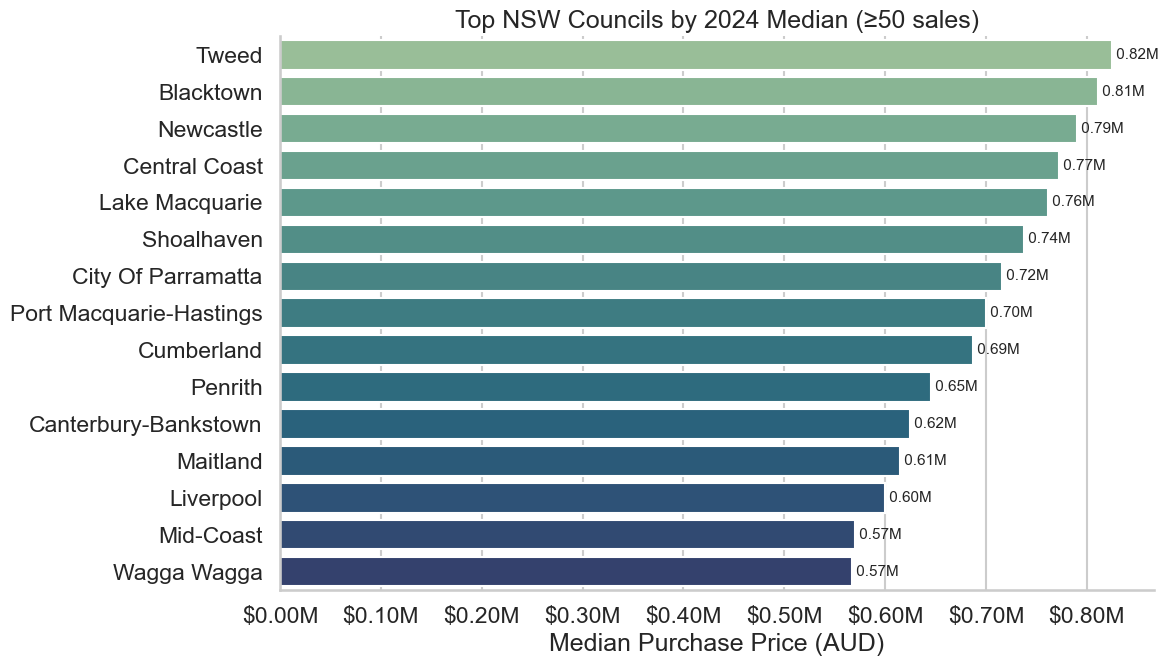

In [20]:
df = pd.read_csv("nsw_affordability_core_2019_2024.csv", parse_dates=["contract_date"])
if "contract_year" not in df: df["contract_year"] = df["contract_date"].dt.year

d2024 = df[df["contract_year"]==2024]
top2024 = (d2024.groupby("council_name")["purchase_price"].median()
           .rename("median_2024").to_frame()
           .join(d2024.groupby("council_name").size().rename("n"))
           .query("n>=50").sort_values("median_2024", ascending=True).head(15).iloc[::-1])

plt.figure(figsize=(12,7))
ax = sns.barplot(data=top2024, y=top2024.index, x="median_2024", palette="crest")
ax.xaxis.set_major_formatter(FuncFormatter(fmt_dollars))
ax.set(title="Top NSW Councils by 2024 Median (≥50 sales)", xlabel="Median Purchase Price (AUD)", ylabel="")
for c, v in enumerate(top2024["median_2024"]):
    ax.text(v, c, f" {v/1e6:.2f}M", va="center", ha="left", fontsize=11)
plt.tight_layout(); 
plt.show()
#plt.savefig("sb_top_2024_median_bar.png", dpi=250); plt.show()


C:\Users\shrey\AppData\Local\Temp\ipykernel_18404\2340145354.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top, y="council_name", x="cagr", palette="magma")


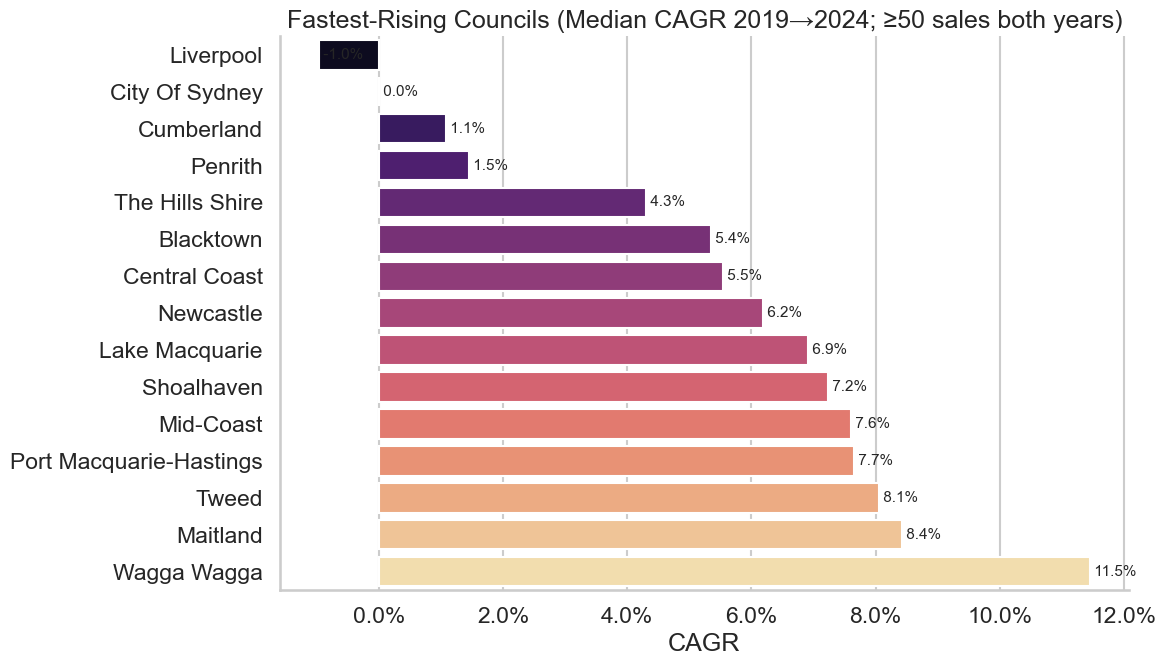

In [21]:
agg = df.groupby(["council_name","contract_year"])["purchase_price"].median().reset_index(name="m")
vol = df.groupby(["council_name","contract_year"]).size().reset_index(name="n")
coy = agg.merge(vol, on=["council_name","contract_year"])
c2019 = coy.query("contract_year==2019 & n>=50")[["council_name","m"]].rename(columns={"m":"m2019"})
c2024 = coy.query("contract_year==2024 & n>=50")[["council_name","m"]].rename(columns={"m":"m2024"})
g = c2019.merge(c2024, on="council_name").query("m2019>0").copy()
g["cagr"] = (g["m2024"]/g["m2019"])**(1/5)-1
top = g.sort_values("cagr", ascending=False).head(15).iloc[::-1]

plt.figure(figsize=(12,7))
ax = sns.barplot(data=top, y="council_name", x="cagr", palette="magma")
ax.xaxis.set_major_formatter(lambda x,pos: f"{x*100:.1f}%")
ax.set(title="Fastest-Rising Councils (Median CAGR 2019→2024; ≥50 sales both years)", xlabel="CAGR", ylabel="")
for c, v in enumerate(top["cagr"]):
    ax.text(v, c, f" {v*100:.1f}%", va="center", ha="left", fontsize=11)
plt.tight_layout(); 
plt.show()
#plt.savefig("sb_fastest_cagr_bar.png", dpi=250); plt.show()


C:\Users\shrey\AppData\Local\Temp\ipykernel_18404\1764872791.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top2024, y=top2024.index, x="median_2024", palette="rocket_r")


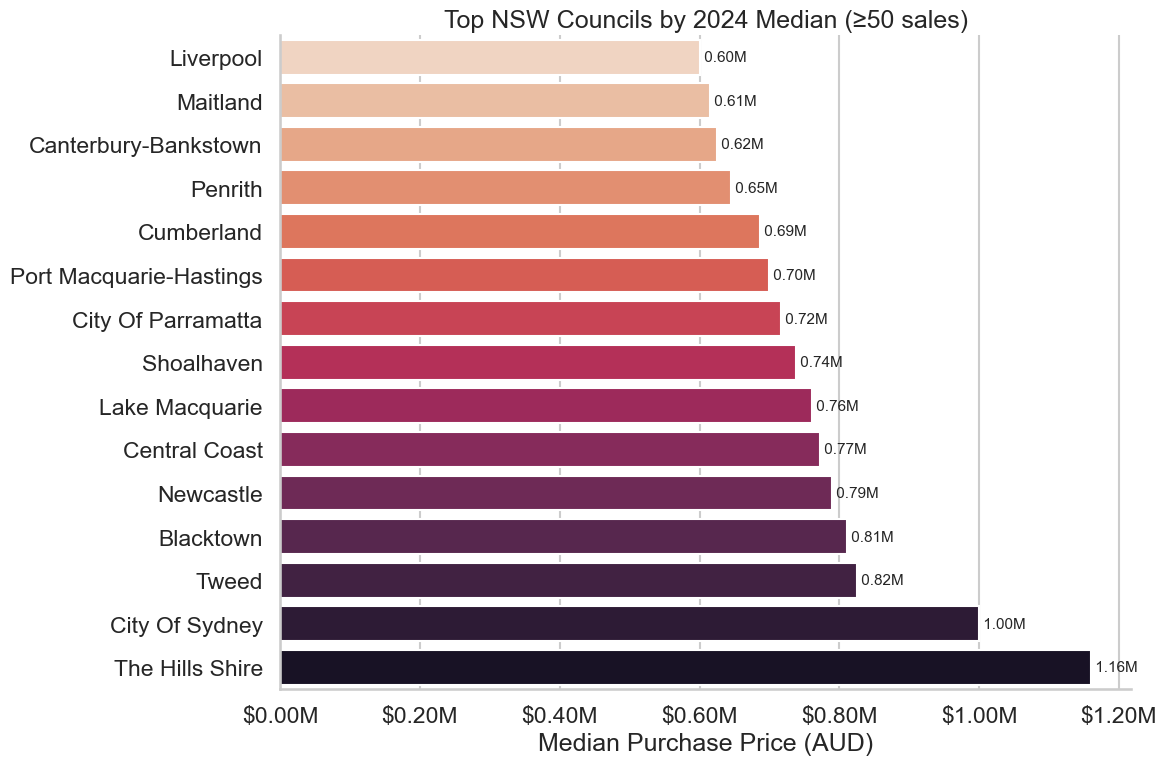

In [22]:
df = pd.read_csv("nsw_affordability_core_2019_2024.csv", parse_dates=["contract_date"])
if "contract_year" not in df.columns:
    df["contract_year"] = df["contract_date"].dt.year
df["council_name_std"] = df["council_name"].str.title()

d2024 = df[df["contract_year"]==2024]
top2024 = (
    d2024.groupby("council_name_std")["purchase_price"].median().rename("median_2024").to_frame()
    .join(d2024.groupby("council_name_std").size().rename("n"))
    .query("n >= 50")
    .sort_values("median_2024", ascending=False)
    .head(15)
    .iloc[::-1]   # small→large so the biggest ends up at the top of the barh
)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top2024, y=top2024.index, x="median_2024", palette="rocket_r")
ax.xaxis.set_major_formatter(FuncFormatter(fmt_dollars))
ax.set(title="Top NSW Councils by 2024 Median (≥50 sales)",
       xlabel="Median Purchase Price (AUD)", ylabel="")

# label each bar
for i, v in enumerate(top2024["median_2024"]):
    ax.text(v, i, f" {v/1e6:.2f}M", va="center", ha="left", fontsize=11)

plt.tight_layout()
# plt.savefig("sb_top_2024_median_bar.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\shrey\AppData\Local\Temp\ipykernel_18404\331136439.py:81: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.annotate(name, (float(r["distance_km"]), float(r["median_2019_2024"])),


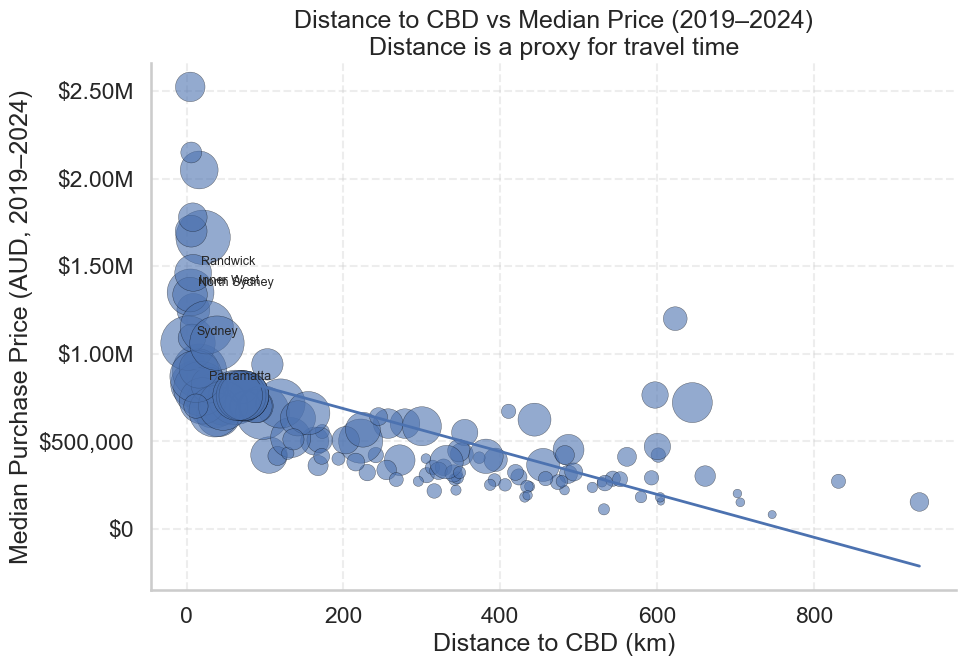

<Figure size 640x480 with 0 Axes>

In [23]:
import pandas as pd, geopandas as gpd, matplotlib.pyplot as plt, numpy as np
from matplotlib.ticker import FuncFormatter
from pyproj import Geod
import re

CSV = "nsw_affordability_core_2019_2024.csv"
SHP = "nsw_lga.shp"

def std(s):
    s = str(s).replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s, flags=re.I).strip()
    s = re.sub(r"(?i)\bcity of\b|\bof the\b", "", s)
    s = re.sub(r"(?i)\b(city council|regional council|municipal council|shire council|council|regional|city|shire)\b", "", s)
    return re.sub(r"\s+", " ", s).strip().title()

def money(x, pos):  # $1.23M style
    return f"${x/1e6:.2f}M" if x>=1e6 else f"${x:,.0f}"

# --- load + name standardise ---
df = pd.read_csv(CSV, parse_dates=["contract_date"])
df["council_name_std"] = df["council_name"].map(std)

gdf = gpd.read_file(SHP)
name_col = next((c for c in ["Lga_name","LGA_NAME","NSW_LGA","NAME","NAME_1"] if c in gdf.columns), gdf.columns[0])
gdf["lga_name_std"] = gdf[name_col].map(std)

# --- medians & volume (2019–2024) ---
med = df.groupby("council_name_std")["purchase_price"].median().reset_index(name="median_2019_2024")
vol = df.groupby("council_name_std").size().reset_index(name="n_txn")

# --- safe centroids (meters) -> WGS84, then geodesic distance to CBD ---
gdf_m = gdf.to_crs(3857).copy()
gdf_m["centroid_m"] = gdf_m.geometry.centroid
centroids_wgs = gpd.GeoSeries(gdf_m["centroid_m"], crs=3857).to_crs(4326)

gdf_wgs = gdf.to_crs(4326).copy()
gdf_wgs["centroid"] = centroids_wgs

CBD_LAT, CBD_LON = -33.8730, 151.2060
geod = Geod(ellps="WGS84")
def dist_km(pt):
    lon, lat = pt.x, pt.y
    _,_,d = geod.inv(CBD_LON, CBD_LAT, lon, lat)
    return d/1000

gdf_wgs["distance_km"] = gdf_wgs["centroid"].apply(dist_km)

# --- join & prep plot frame ---
X = (gdf_wgs[["lga_name_std","distance_km"]]
     .merge(med, left_on="lga_name_std", right_on="council_name_std", how="left")
     .merge(vol, on="council_name_std", how="left")
     .dropna(subset=["median_2019_2024"]))

# point sizes by volume (cap to avoid huge circles)
size = 20 + 0.06 * X["n_txn"].clip(upper=X["n_txn"].quantile(0.95))

fig, ax = plt.subplots(figsize=(10,7))
sc = ax.scatter(X["distance_km"], X["median_2019_2024"],
                s=size, alpha=0.6, edgecolor="black", linewidth=0.3)

# trend line (simple linear fit)
x = X["distance_km"].to_numpy()
y = X["median_2019_2024"].to_numpy()
m,b = np.polyfit(x, y, 1)
xline = np.linspace(x.min(), x.max(), 200)
ax.plot(xline, m*xline + b, linewidth=2)

# labels & cosmetics
ax.yaxis.set_major_formatter(FuncFormatter(money))
ax.set_xlabel("Distance to CBD (km)")
ax.set_ylabel("Median Purchase Price (AUD, 2019–2024)")
ax.set_title("Distance to CBD vs Median Price (2019–2024)\nDistance is a proxy for travel time")

ax.grid(axis="both", linestyle="--", alpha=0.35)
for spine in ("top","right"): ax.spines[spine].set_visible(False)

# annotate a few key councils
for name in ["Sydney","North Sydney","Inner West","Parramatta","The Hills Shire","Randwick"]:
    r = X.loc[X["lga_name_std"]==name]
    if not r.empty:
        ax.annotate(name, (float(r["distance_km"]), float(r["median_2019_2024"])),
                    xytext=(6,6), textcoords="offset points", fontsize=9)

plt.tight_layout()
plt.show()
plt.savefig("distance_vs_price_scatter_pretty.png", dpi=470, bbox_inches="tight")

# --- export evidence (numbers behind the chart) ---
evidence = X[["lga_name_std","distance_km","median_2019_2024","n_txn"]].sort_values("distance_km")
# evidence.to_csv("distance_vs_price_evidence.csv", index=False)


In [24]:
# --- Build g_all_m and syd_m from scratch ---
import os, re
import pandas as pd, geopandas as gpd

CSV = "nsw_affordability_core_2019_2024.csv"
SHP = "nsw_lga.shp"

# let GDAL rebuild missing .shx if needed
os.environ["SHAPE_RESTORE_SHX"] = "YES"

def std(s: str) -> str:
    s = str(s).replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s, flags=re.I).strip()
    s = re.sub(r"(?i)\bcity of\b|\bof the\b", "", s)
    s = re.sub(r"(?i)\b(city council|regional council|municipal council|shire council|council|regional|city|shire)\b", "", s)
    return re.sub(r"\s+", " ", s).strip().title()

# 1) Load sales and keep 2019–2024
df = pd.read_csv(CSV, parse_dates=["contract_date"])
if "contract_year" not in df.columns:
    df["contract_year"] = df["contract_date"].dt.year
df = df.dropna(subset=["purchase_price","council_name","contract_year"])
df = df[(df["contract_year"] >= 2019) & (df["contract_year"] <= 2024)]
df["purchase_price"] = pd.to_numeric(df["purchase_price"], errors="coerce")
df["council_name_std"] = df["council_name"].map(std)

# 2) Council medians across 2019–2024
med = (df.groupby("council_name_std")["purchase_price"]
         .median()
         .reset_index(name="median_price_2019_2024"))

# 3) Load shapefile and standardise names
gdf = gpd.read_file(SHP)
name_col = next((c for c in ["Lga_name","LGA_NAME","LGA_NAME21","LGA_NAME20","NSW_LGA","NAME","NAME_1"]
                 if c in gdf.columns), gdf.columns[0])
gdf["lga_name_std"] = gdf[name_col].map(std)

# 4) Join medians onto shapes
g_all = gdf.merge(med, left_on="lga_name_std", right_on="council_name_std", how="left")

# 5) Project to meters (EPSG:3857) for distances/label spacing
g_all_m = g_all.to_crs(3857)

# 6) Grab the City of Sydney polygon (post-standardisation it should be 'Sydney')
syd_m = g_all_m[g_all_m["lga_name_std"] == "Sydney"]
if syd_m.empty:
    # fallback: any LGA whose raw name contains 'Sydney'
    syd_m = g_all_m[g_all_m[name_col].str.contains("Sydney", case=False, na=False)]
    if syd_m.empty:
        raise ValueError("Couldn’t find the City of Sydney in the shapefile. "
                         "Print g_all_m['lga_name_std'].unique() to inspect names.")

# (Optional) if your plotting block expects a different column name:
if "median_2019_2024" in g_all_m.columns and "median_price_2019_2024" not in g_all_m.columns:
    g_all_m = g_all_m.rename(columns={"median_2019_2024":"median_price_2019_2024"})

print("Ready: g_all_m (NSW in meters) and syd_m (City of Sydney) are defined.")

# ========= TWEAKABLES =========
REGIONAL_KM = 100           # label councils at least this far from Sydney
MIN_LABEL_SPACING_KM = 30   # keep labels this far apart
MIN_AREA_SQ_KM = 150        # avoid tiny polygons
FONT_SIZE = 9
BINS_Q = [0.05, 0.25, 0.5, 0.75, 0.90, 0.98]  # quantile breaks for color bins
CMAP = "YlOrRd"             # conveys "heat" (affordability pressure)
EDGE_COLOR = "white"
EDGE_LW = 0.4
TITLE = "Regional NSW — Median Property Price by Council (2019–2024)"
SUBTITLE = f"Labels shown ≥{REGIONAL_KM} km from CBD; medians; outliers capped via quantile bins"
# ==============================

def money_millions(x, pos):
    return f"${x/1e6:.1f}M"

def add_north_arrow(ax, xy=(0.06, 0.14), length=0.06):
    ax.annotate('N', xy=xy, xycoords='axes fraction',
                xytext=(xy[0], xy[1]+length), textcoords='axes fraction',
                ha='center', va='center', fontsize=12, fontweight='bold',
                arrowprops=dict(facecolor='black', width=4, headwidth=12, shrink=0.0))

def add_scale_bar(ax, meters=50000, label="50 km"):
    fontprops = FontProperties(size=9)
    sb = AnchoredSizeBar(ax.transData, meters, label, 'lower right',
                         pad=0.4, color='black', frameon=False,
                         size_vertical=1500, fontproperties=fontprops)
    ax.add_artist(sb)

# ---------- assume g_all_m (EPSG:3857) & syd_m exist ----------
mainland = g_all_m[~g_all_m["lga_name_std"]
                   .str.contains("Lord Howe", case=False, na=False)].copy()

# Sydney reference
syd_union = syd_m.geometry.unary_union
syd_centroid = syd_union.centroid

# Representative points (more robust than centroids for labeling)
mainland["_pt"] = mainland.geometry.representative_point()
mainland["_dist_m"] = mainland["_pt"].distance(syd_centroid)
mainland["_area_m2"] = mainland.geometry.area

# Regional filter for labeling
regional = mainland[
    (mainland["_dist_m"] >= REGIONAL_KM * 1000) &
    (mainland["_area_m2"] >= MIN_AREA_SQ_KM * 1_000_000)
].copy()

# Greedy spacing: prefer larger polygons, keep labels apart
regional = regional.sort_values("_area_m2", ascending=False)
selected_idx, selected_pts = [], []
for idx, row in regional.iterrows():
    pt = row["_pt"]
    if all(pt.distance(other) >= MIN_LABEL_SPACING_KM * 1000 for other in selected_pts):
        selected_idx.append(idx)
        selected_pts.append(pt)
labels_df = regional.loc[selected_idx]

# ----- color bins (quantiles) for strong contrast, robust to outliers -----
vals = mainland["median_price_2019_2024"].dropna().to_numpy()
q = np.unique(np.quantile(vals, BINS_Q))
if len(q) < 3:  # fallback if not enough unique values
    q = np.linspace(vals.min(), vals.max(), 6)
norm = BoundaryNorm(q, ncolors=plt.get_cmap(CMAP).N, clip=True)

# ----- plot -----
fig, ax = plt.subplots(figsize=(12, 9), dpi=220)
ax.set_facecolor("#f7f7f7")

# base polygons
mainland.plot(
    ax=ax,
    column="median_price_2019_2024",
    cmap=CMAP,
    norm=norm,
    edgecolor=EDGE_COLOR,
    linewidth=EDGE_LW,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# emphasize City of Sydney boundary for context
syd_m.boundary.plot(ax=ax, color="red", linewidth=1.2)

# labels with white halo
for (x, y), label in zip(labels_df["_pt"].apply(lambda g: (g.x, g.y)), labels_df["lga_name_std"]):
    t = ax.text(x, y, label, fontsize=FONT_SIZE, ha="center", va="center")
    t.set_path_effects([pe.withStroke(linewidth=2.8, foreground="white")])

# nice colorbar with money ticks
sm = plt.cm.ScalarMappable(cmap=CMAP, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.030, pad=0.015)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(money_millions))
cbar.set_label("Median Purchase Price (AUD)", rotation=90)

# title/subtitle & cosmetics
ax.set_title(TITLE, loc="left", pad=8, fontsize=14, fontweight="bold")
ax.text(0.01, 0.96, SUBTITLE, transform=ax.transAxes, fontsize=9, color="#555555")
for spine in ("top", "right", "left", "bottom"):
    ax.spines[spine].set_visible(False)
ax.axis("off")

# bounds
xmin, ymin, xmax, ymax = mainland.total_bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

# north arrow + scale bar
add_north_arrow(ax)
add_scale_bar(ax, meters=50_000, label="50 km")  # auto in 3857 meters

plt.tight_layout()
plt.show()
# plt.savefig("regional_nsw_median_pretty.png", bbox_inches="tight")


Ready: g_all_m (NSW in meters) and syd_m (City of Sydney) are defined.


C:\Users\shrey\AppData\Local\Temp\ipykernel_18404\4269272515.py:93: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  syd_union = syd_m.geometry.unary_union


NameError: name 'BoundaryNorm' is not defined

C:\Users\shrey\AppData\Local\Temp\ipykernel_19728\1513261189.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top15, y=top15.index, x="avg_price", palette="crest")


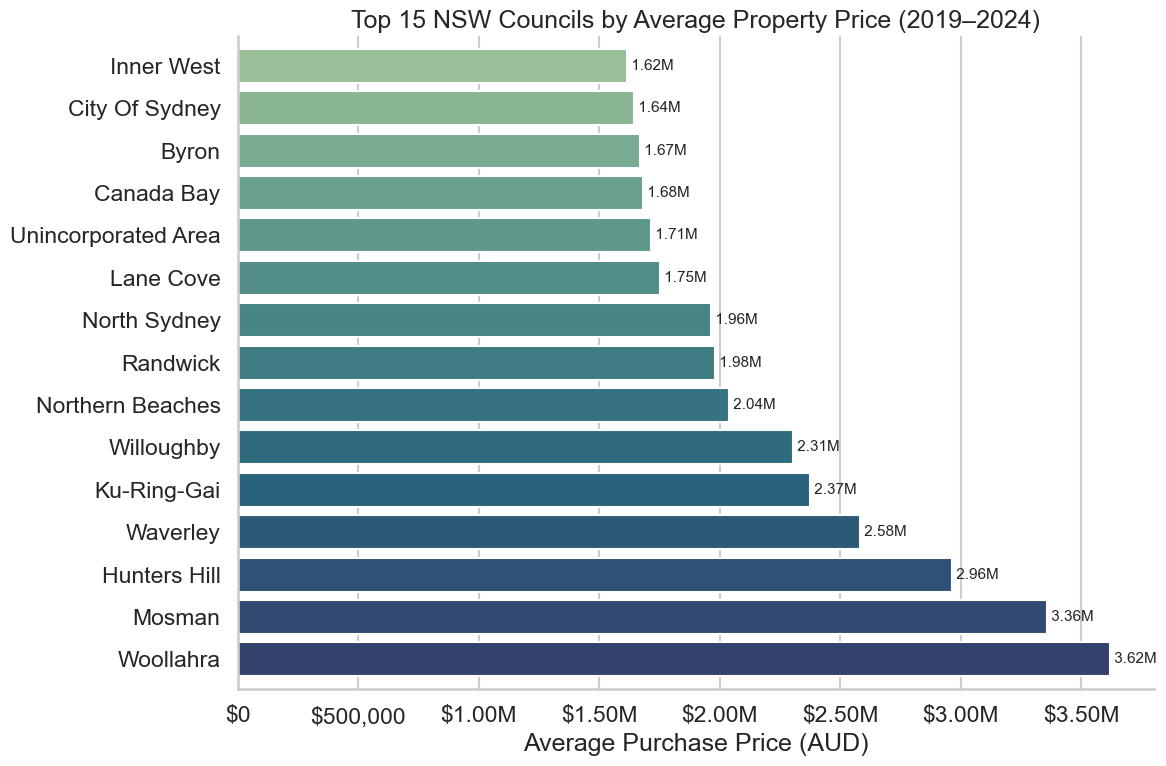

In [ ]:
# pip install seaborn
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid", context="talk",
              rc={"axes.spines.top": False, "axes.spines.right": False})

def fmt_dollars(x, pos):
    # $1.23M formatting
    return f"${x/1e6:.2f}M" if x >= 1e6 else f"${x:,.0f}"

# --- load ---
df = pd.read_csv("nsw_affordability_core_2019_2024.csv")

# --- aggregate (mean like your code). To use median instead, change 'mean' -> 'median' below ---
agg = (df.groupby("council_name")["purchase_price"]
         .mean()                          # <- swap to .median() if preferred
         .rename("avg_price")
         .to_frame()
         .join(df.groupby("council_name").size().rename("n")))

top15 = (agg.sort_values("avg_price", ascending=False)
             .head(15)
             .iloc[::-1])                 # reverse so largest appears at top in barh

# --- plot ---
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top15, y=top15.index, x="avg_price", palette="crest")

# axes & title
ax.xaxis.set_major_formatter(FuncFormatter(fmt_dollars))
ax.set(title="Top 15 NSW Councils by Average Property Price (2019–2024)",
       xlabel="Average Purchase Price (AUD)", ylabel="")

# value labels on bars
for i, v in enumerate(top15["avg_price"]):
    ax.text(v, i, f" {v/1e6:.2f}M" if v >= 1e6 else f" {v:,.0f}",
            va="center", ha="left", fontsize=11)

# nice margins
ax.margins(y=0.02)
plt.tight_layout()
# plt.savefig("sb_top15_avg_price.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\shrey\AppData\Local\Temp\ipykernel_19728\3640517619.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["distance_band","property_type"])["median_2019_2024"]


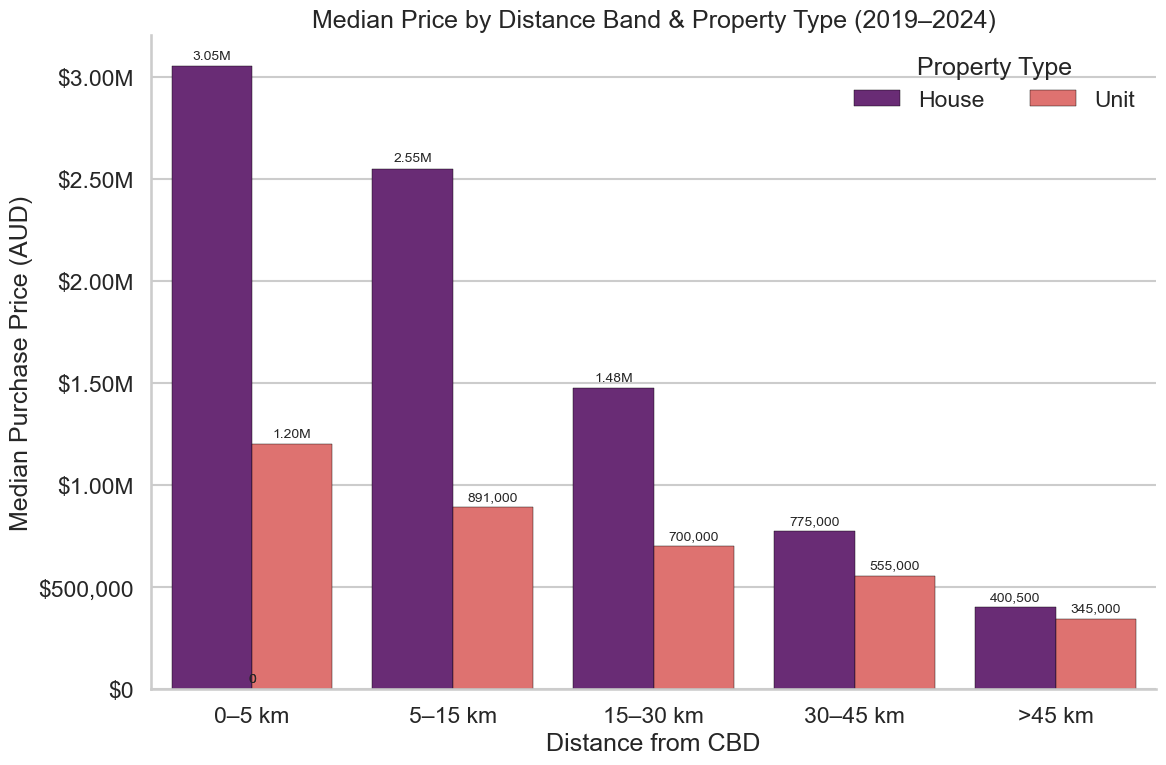

Saved evidence: house_unit_by_distance_band_evidence.csv, lga_distance_to_cbd.csv


In [ ]:
# pip install seaborn geopandas pyproj shapely matplotlib
import os, re
from pathlib import Path
import pandas as pd, geopandas as gpd, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.ticker import FuncFormatter
from pyproj import Geod

# ---------- theming ----------
sns.set_theme(style="whitegrid", context="talk",
              rc={"axes.spines.top": False, "axes.spines.right": False})

def fmt_dollars(x, pos):
    return f"${x/1e6:.2f}M" if x >= 1e6 else f"${x:,.0f}"

# ---------- inputs ----------
CSV_CANDIDATES = [
    "nsw_affordability_core_2019_2024.csv",
    "nsw_property_data_cleaned_2019_onwards.csv",
    "nsw_property_data_2019_onwards.csv",
]
SHP = Path("nsw_lga.shp")
os.environ["SHAPE_RESTORE_SHX"] = "YES"   # let GDAL recreate .shx if missing

# ---------- helpers ----------
def std(s: str) -> str:
    s = str(s).replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s, flags=re.I).strip()
    s = re.sub(r"(?i)\bcity of\b|\bof the\b", "", s)
    s = re.sub(r"(?i)\b(city council|regional council|municipal council|shire council|council|regional|city|shire)\b", "", s)
    return re.sub(r"\s+", " ", s).strip().title()

# ---------- load CSV ----------
CSV = next((p for p in CSV_CANDIDATES if Path(p).exists()), None)
if not CSV:
    raise FileNotFoundError("Could not find any CSV: " + ", ".join(CSV_CANDIDATES))

df = pd.read_csv(CSV, low_memory=False,
                 parse_dates=["contract_date"] if "contract_date" in pd.read_csv(CSV, nrows=1).columns else None)

# ensure core columns
if "council_name" not in df.columns:
    for alt in ["lga_name","lga","council"]:
        if alt in df.columns: df = df.rename(columns={alt:"council_name"}); break
if "purchase_price" not in df.columns:
    for alt in ["price","sale_price"]:
        if alt in df.columns: df = df.rename(columns={alt:"purchase_price"}); break
if "contract_year" not in df.columns:
    df["contract_year"] = pd.to_datetime(df.get("contract_date"), errors="coerce").dt.year

# filter & clean
df = df.dropna(subset=["purchase_price","council_name"])
df["purchase_price"] = pd.to_numeric(df["purchase_price"], errors="coerce")
df = df[(df["contract_year"] >= 2019) & (df["contract_year"] <= 2024)]
df = df[(df["purchase_price"] >= 10_000) & (df["purchase_price"] <= 20_000_000)]
df["council_name_std"] = df["council_name"].map(std)

# property_type cleanup
if "property_type" not in df.columns:
    df["property_type"] = "All"
else:
    t = df["property_type"].astype("string").str.lower().str.strip()
    df["property_type"] = (
        t.replace({
            "house":"house","detached":"house","freestanding":"house",
            "unit":"unit","apartment":"unit","flat":"unit","studio":"unit","townhouse":"unit",
        })
        .where(lambda s: s.isin(["house","unit"]), other="other")
        .str.title()
    )

# ---------- medians by council × type (2019–2024 window) ----------
med = (df.groupby(["council_name_std","property_type"])["purchase_price"]
         .median().reset_index(name="median_2019_2024"))

# ---------- load shapefile & standardise ----------
if not SHP.exists():
    raise FileNotFoundError("Missing shapefile. Put nsw_lga.shp, .shx, .dbf, .prj in the same folder.")
try:
    gdf = gpd.read_file(SHP)  # pyogrio default
except Exception:
    gdf = gpd.read_file(SHP, engine="fiona")

name_col = next((c for c in ["Lga_name","LGA_NAME","NSW_LGA","NAME","NAME_1","LGA_NAME21","LGA_NAME20"]
                 if c in gdf.columns), gdf.columns[0])
gdf["lga_name_std"] = gdf[name_col].map(std)

# ---------- safe centroids (meters) → geodesic distance (km) ----------
gdf_m = gdf.to_crs(3857).copy()
gdf_m["centroid_m"] = gdf_m.geometry.centroid
centroids_wgs = gpd.GeoSeries(gdf_m["centroid_m"], crs=3857).to_crs(4326)
gdf_wgs = gdf.to_crs(4326).copy()
gdf_wgs["centroid"] = centroids_wgs

CBD_LAT, CBD_LON = -33.8730, 151.2060  # Sydney Town Hall
geod = Geod(ellps="WGS84")
def dist_km(pt):
    lon, lat = pt.x, pt.y
    _, _, d = geod.inv(CBD_LON, CBD_LAT, lon, lat)
    return d/1000.0

gdf_wgs["distance_km"] = gdf_wgs["centroid"].apply(dist_km)

# ---------- join distances with medians ----------
X = gdf_wgs[["lga_name_std","distance_km"]].merge(
        med, left_on="lga_name_std", right_on="council_name_std", how="left"
    )

# ---------- distance bands ----------
labels = ["0–5 km","5–15 km","15–30 km","30–45 km",">45 km"]
bins = [0, 5, 15, 30, 45, 1e9]
X["distance_band"] = pd.cut(X["distance_km"], bins=bins, labels=labels, include_lowest=True, right=True)
X["distance_band"] = pd.Categorical(X["distance_band"], categories=labels, ordered=True)

band_med = (X.dropna(subset=["median_2019_2024","distance_band"])
              .groupby(["distance_band","property_type"])["median_2019_2024"]
              .median().reset_index())

# ---------- seaborn grouped bars ----------
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=band_med,
    x="distance_band",
    y="median_2019_2024",
    hue="property_type",
    palette="magma",
    edgecolor="black",
    linewidth=0.3
)

ax.yaxis.set_major_formatter(FuncFormatter(fmt_dollars))
ax.set(
    title="Median Price by Distance Band & Property Type (2019–2024)",
    xlabel="Distance from CBD",
    ylabel="Median Purchase Price (AUD)"
)

# tidy legend (hide if only one category)
handles, labels_ = ax.get_legend_handles_labels()
if band_med["property_type"].nunique() <= 1:
    ax.legend_.remove()
else:
    ax.legend(title="Property Type", frameon=False, ncol=3)

# value labels on bars
for p in ax.patches:
    height = p.get_height()
    if pd.isna(height): 
        continue
    ax.annotate(
        f"{height/1e6:.2f}M" if height >= 1e6 else f"{height:,.0f}",
        (p.get_x() + p.get_width()/2., height),
        ha="center", va="bottom", fontsize=10, xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
# plt.savefig("sb_house_unit_by_distance_band.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------- evidence ----------
band_med.to_csv("house_unit_by_distance_band_evidence.csv", index=False)
X[["lga_name_std","distance_km"]].drop_duplicates().sort_values("distance_km").to_csv("lga_distance_to_cbd.csv", index=False)
print("Saved evidence: house_unit_by_distance_band_evidence.csv, lga_distance_to_cbd.csv")
